# Reflection Analytics

Time Period: **Week 6**

This notebook is based on the csv extracted from Quercus from individual "Reflections" pages, by clicking on the "Student Analysis" tab. All student personal data has been removed, and the notebook only deals with aggregated groups (i.e. lecture assigned, engineering discipline). The results are based on the students who have completed a reflection for this week.

## Data Sources
General sources (kept between weeks in `class_data` folder):
- `ClassList-20231-APS106H1-S.csv`: sheet from department
- `vader_lexicon.txt`: used for sentiment analysis

## Summary of Analysis
This notebook is broken into the following sub-sections:
1. Student Attendance
2. Comfort with Topics 
3. Confusing Topics
4. Sentiment Analysis

# Define Imports

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly
import matplotlib

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import warnings
warnings.filterwarnings('ignore')

/Users/ekaterinaossetchkina/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Initialize Variables

In [2]:
week = 6

lecture_name = {
    "LEC0101": "Kinsella & Goodfellow",
    "LEC0102": "Moosavi",
    "LEC0103": "Beck"
}

lecture = [
         'Lecture 1',
         'Lecture 2',
         'Lecture 3']

lectures = [
            'Kinsella & Goodfellow', 
            'Moosavi', 
            'Beck']

section = ['LEC0101','LEC0102','LEC0103']

disciplines = [
    'Mechanical',
    'Industrial',
    'Materials',
    'Chemical',
    'Non-Degree',
    'Track-One',
    'Mineral',
    'Civil'
]

plt.style.use('fivethirtyeight')
colors = ['#ADD8E6','#ffcc99','#98AFC7','#ff9999','#d7edb9','#c4bcc0','#67805c','#ab446c','#41734f','#eb4034']

# Read in Data

In [3]:
# Student Data
student_data_path = "../class_data/ClassList-20241-APS106H1-S.csv" 
students_df = pd.read_csv(student_data_path)

# Reflection Data
reflection_path = "week" + str(week) + "_raw.csv"
reflections_df = pd.read_csv(reflection_path)

# Preprocessing Data

In [4]:
# Remove column names up to the outputted number
reflections_df.columns[-4]

'1.0.12'

In [5]:
# Remove the "attempt" and question score columns auto-generated by quercus
reflections_df = reflections_df.drop(columns=['attempt','1.0', '1.0.1','1.0.2','1.0.3','1.0.4',
        '1.0.4','1.0.5','1.0.6','1.0.7','1.0.8','1.0.9','1.0.10','1.0.11', '1.0.12', 
                                              'n correct', 'n incorrect', 'score'])

# Rename columns in dataframe 
current_column_names = list(reflections_df.columns)

column_names = {
    current_column_names[7]: "lecture_sections",
    current_column_names[8]: "lecture_reasons",
    current_column_names[9]: "lecture_alternate_section",
    current_column_names[10]: "hybrid_learning",
    current_column_names[11]: "tutorial_sections",
    current_column_names[12]: "video_materials", 
    current_column_names[13]: "practical_sections",  
    current_column_names[14]: "practice_problems",
    current_column_names[15]: "progress_check",
    current_column_names[16]: "comment_one_word",  
    current_column_names[17]: "confused_topics",
    current_column_names[18]: "for_loop_check",
    current_column_names[19]: "feedback", 
    }

reflections_df.rename(columns=column_names, inplace=True)

# 3 - join reflection data with student data based on UTORid 
combined_df = reflections_df.merge(students_df, left_on = "sis_id", right_on = "UTORid", how="left")

# 4 - rename disciplines from the POSt Code 
combined_df['POSt Code'] = combined_df['POSt Code'].str.rstrip("X")

disciplines = {
    "AECHEBASC": "Chemical",
    "AECIVBASC": "Civil",
    "AEMECBASC": "Mechanical",
    "AELMEBASC": "Mineral",
    "AEINDBASC": "Industrial",
    "AEMMSBASC": "Materials",
    "AEENGBASC": "Track-One", 
    "AE   NDEGI": "Non-Degree"
    }

combined_df['discipline'] = combined_df['POSt Code'].map(disciplines)  
combined_df = combined_df.drop(columns = ['Session Code','Activity Code','Section Code',
                                          'POSt Code','Surname','Given Name',
                                          'Year','Email Address','UTORid','name','id','sis_id'])

# 5 - get count of lecture sections attended + reformat to match student information sheet
combined_df['LEC0101_attended'] = np.where(combined_df['lecture_sections'].str.contains("LEC0101"), "LEC0101", False)
combined_df['LEC0102_attended'] = np.where(combined_df['lecture_sections'].str.contains("LEC0102"), "LEC0102", False)
combined_df['LEC0103_attended'] = np.where(combined_df['lecture_sections'].str.contains("LEC0103"), "LEC0103", False)

combined_df['lecture_assigned'] = np.where(np.logical_or(combined_df['LEC0103_attended'] == combined_df['Lecture'], 
                                np.logical_or(combined_df['LEC0101_attended'] == combined_df['Lecture'],
                                combined_df['LEC0102_attended'] == combined_df['Lecture'])), True, False) 

# Polarity prep

# 1 - remove all punctuation from student paragraph, lower all strings
punctuations = '!"#$%&\'()*+-./:;<=>?@@[\\]^_`{|}~“' 
esc_char = "\xa0"

def remove_punctuations(text):
    text = str(text)
    for x in punctuations:
        if (x in text):
            text=text.replace(x," ")
    return text

combined_df['cleaned_answer'] = combined_df.apply(lambda row: remove_punctuations(text=row['comment_one_word']),axis=1)
combined_df['cleaned_answer'] = combined_df['cleaned_answer'].str.lower()

# 2 - each word from the reflection will be separated into its own row in a new dataframe
word_lookup = (combined_df['cleaned_answer'].str.split(' ', expand=True).stack().reset_index(name='word'))
word_lookup = word_lookup[word_lookup.word != '']
word_lookup = word_lookup.set_index('level_0',drop=True).rename(columns={'level_1':'num'})


# 3 - introduce lexicon to look up polarity values for each word 
# '../class_data/vader_lexicon.txt'
file = open('../class_data/vader_lexicon.txt', 'r').read().split('\n')
lexicon_text = [x for x in file[0:]]

lexicon =  pd.DataFrame(lexicon_text,columns=['data'])
lexicon = lexicon['data'].str.split('\t',expand=True)
lexicon = lexicon[[0,1]].rename(columns={0: "word", 1: "polarity"}).set_index('word')

# 4 - look up each word inside the long answer, assign a polarity
word_lookup = word_lookup.join(lexicon, on ='word')
word_lookup.fillna(0, inplace=True)

# 5 - aggregate dataframe back to sum polarity per long answer
word_lookup[["polarity"]] = word_lookup[["polarity"]].apply(pd.to_numeric)
polarity = word_lookup.groupby(['level_0'])['polarity'].sum().to_frame()

# 6 - join polarity data back into combined_df
combined_df = combined_df.join(polarity)

# add a new column that counts number of lectures attended by student
combined_df['lecture_count'] = combined_df['lecture_sections'].str.count('\\\\')
combined_df['lecture_count'] = combined_df['lecture_count'].fillna(0)

# export cleaned dataframe into csv
combined_df.to_csv('reflection{}.csv'.format(week))
combined_df.head()

section              section_id  \
0  APS106H1-S-LEC0101-20241, APS106H1-S-PRA0108-2...  320111, 320270, 320294   
1  APS106H1-S-LEC0102-20241, APS106H1-S-TUT0103-2...  320129, 320294, 320168   
2  APS106H1-S-TUT0102-20241, APS106H1-S-LEC0101-2...  320285, 320111, 320224   
3  APS106H1-S-LEC0101-20241, APS106H1-S-PRA0103-2...  320111, 320231, 320294   
4  APS106H1-S-TUT0108-20241, APS106H1-S-PRA0108-2...  320328, 320270, 320149   

                                      section_sis_id                submitted  \
0  APS106H1-S-LEC0101-20241, APS106H1-S-PRA0108-2...  2024-02-19 06:00:00 UTC   
1  APS106H1-S-LEC0102-20241, APS106H1-S-TUT0103-2...  2024-02-19 06:00:00 UTC   
2  APS106H1-S-TUT0102-20241, APS106H1-S-LEC0101-2...  2024-02-19 05:43:00 UTC   
3  APS106H1-S-LEC0101-20241, APS106H1-S-PRA0103-2...  2024-02-19 05:30:55 UTC   
4  APS106H1-S-TUT0108-20241, APS106H1-S-PRA0108-2...  2024-02-19 05:25:27 UTC   

                                    lecture_sections  \
0                                                NaN   
1  Moosavi (LEC0102) - Lecture 1 (Monday\, 3 - 4 pm)   
2  Moosavi (LEC0102) - Lecture 1 (Monday\, 3 - 4 pm)   
3  Kinsella & Goodfellow (LEC0101) - Lecture 2 (T...   
4  Beck (LEC0103) - Lecture 1 (Monday\, 3 - 4 pm)...   

                                  lecture_reasons  \
0                                             NaN   
1                                             NaN   
2  I was studying for a term test for this course   
3    I was working on assignments for this course   
4                                             NaN   

                           lecture_alternate_section  \
0                                                NaN   
1                                                NaN   
2  I prefer the teaching style in another section(s)   
3  I prefer the room of the lectures in another s...   
4                                                NaN   

                                     hybrid_learning  \
0                                                NaN   
1                                                NaN   
2  Following the lecture by looking at the conten...   
3      Coding along with the instructor on my device   
4  Following the lecture by looking at the conten...   

                       tutorial_sections  \
0                                    NaN   
1                                    NaN   
2  Katia (TUT0108\, Tuesday\, 9 - 10 am)   
3  Katia (TUT0104\, Monday\, 10 - 11 am)   
4  Katia (TUT0108\, Tuesday\, 9 - 10 am)   

                                     video_materials  ... Tutorial Practical  \
0                                                NaN  ...      NaN       NaN   
1                                                NaN  ...      NaN       NaN   
2                LEC0102 - Moosavi Lecture Recording  ...  TUT0102   PRA0102   
3  LEC0101 - Kinsella & Goodfellow Lecture Recording  ...  TUT0103   PRA0103   
4  I did not use or plan to use any recorded mate...  ...  TUT0108   PRA0108   

   discipline LEC0101_attended LEC0102_attended LEC0103_attended  \
0         NaN          LEC0101          LEC0102          LEC0103   
1         NaN            False          LEC0102            False   
2    Chemical            False          LEC0102            False   
3  Mechanical          LEC0101            False            False   
4   Materials            False            False          LEC0103   

  lecture_assigned  cleaned_answer polarity lecture_count  
0            False             nan      0.0           0.0  
1            False             nan      0.0           1.0  
2            False              gg      1.2           1.0  
3             True               ，      0.0           1.0  
4             True            good      1.9           3.0  

[5 rows x 29 columns]

# Number of students who completed reflections

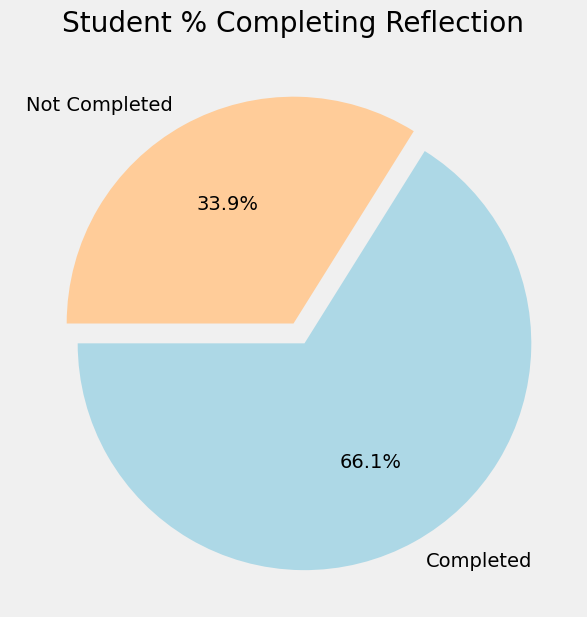

In [34]:
# number of students who completed reflection
completed = len(reflections_df)
not_complete = len(students_df) - completed

# how many students in each tutorial section
plt.figure(figsize=(7,7)) 
plt.title("Student % Completing Reflection")

values = [completed, not_complete]
name = ["Completed", "Not Completed"]

explode = (0.1, 0)

plt.pie(values, labels=name, colors=colors, startangle=-180,autopct='%1.1f%%',explode=explode)
plt.show()

# 1. Student Attendence During Current Week

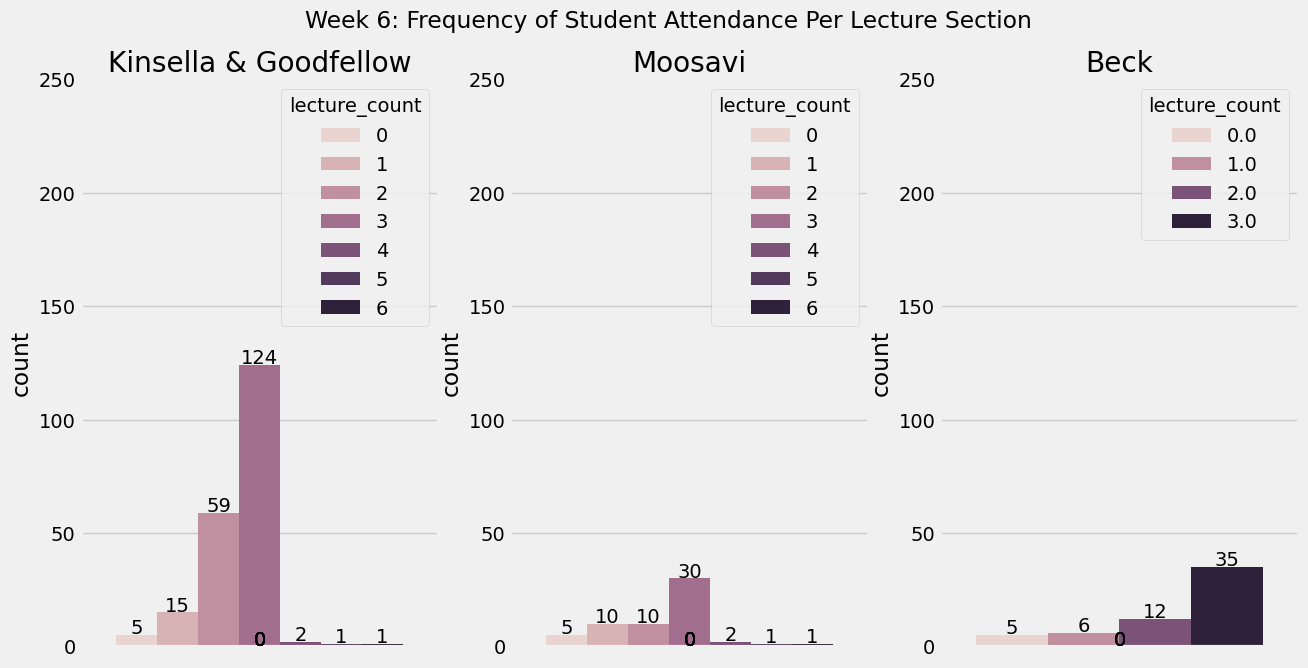

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: Frequency of Student Attendance Per Lecture Section".format(week))

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

for index, value in enumerate(column_list):
    data = combined_df[combined_df[value]==lecture_list[index]]
    sns.countplot(x=value, hue="lecture_count", data=data, ax=axs[index])
    axs[index].get_xaxis().set_visible(False)
    axs[index].set_ylim(0,250)
    axs[index].set_title(lecture_name[lecture_list[index]])

    for i, p in enumerate(axs[index].patches):
        axs[index].annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')


plt.show()

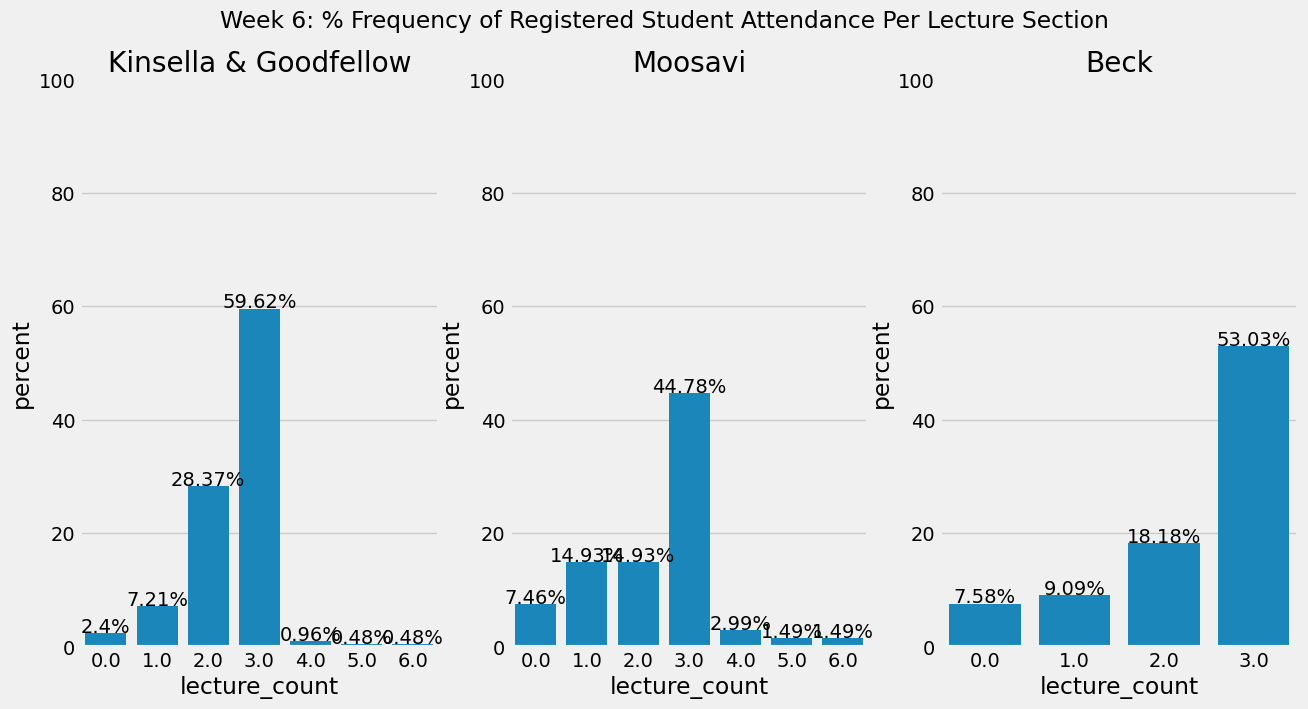

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: % Frequency of Registered Student Attendance Per Lecture Section ".format(week))

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

assigned_lecture = [
    len(combined_df[combined_df["Lecture"]=="LEC0101"]),
    len(combined_df[combined_df["Lecture"]=="LEC0102"]),
    len(combined_df[combined_df["Lecture"]=="LEC0103"])
]

for index, value in enumerate(column_list):

    #filter down the dataframe only to the specific lecturer
    df_temp = combined_df[combined_df[value]==lecture_list[index]]
    df_temp = df_temp.groupby("lecture_count").agg('count')

    df_temp =  df_temp[["section"]].copy().reset_index()
    df_temp['percent'] = df_temp['section'] / assigned_lecture[index] * 100


    sns.barplot(data=df_temp, x="lecture_count", y="percent", ax=axs[index])
    axs[index].set_title(lecture_name[lecture_list[index]])

    axs[index].set_ylim(0,100)

    values = list(df_temp['percent'])

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round((values[i]),2)),ha="center")

plt.show()

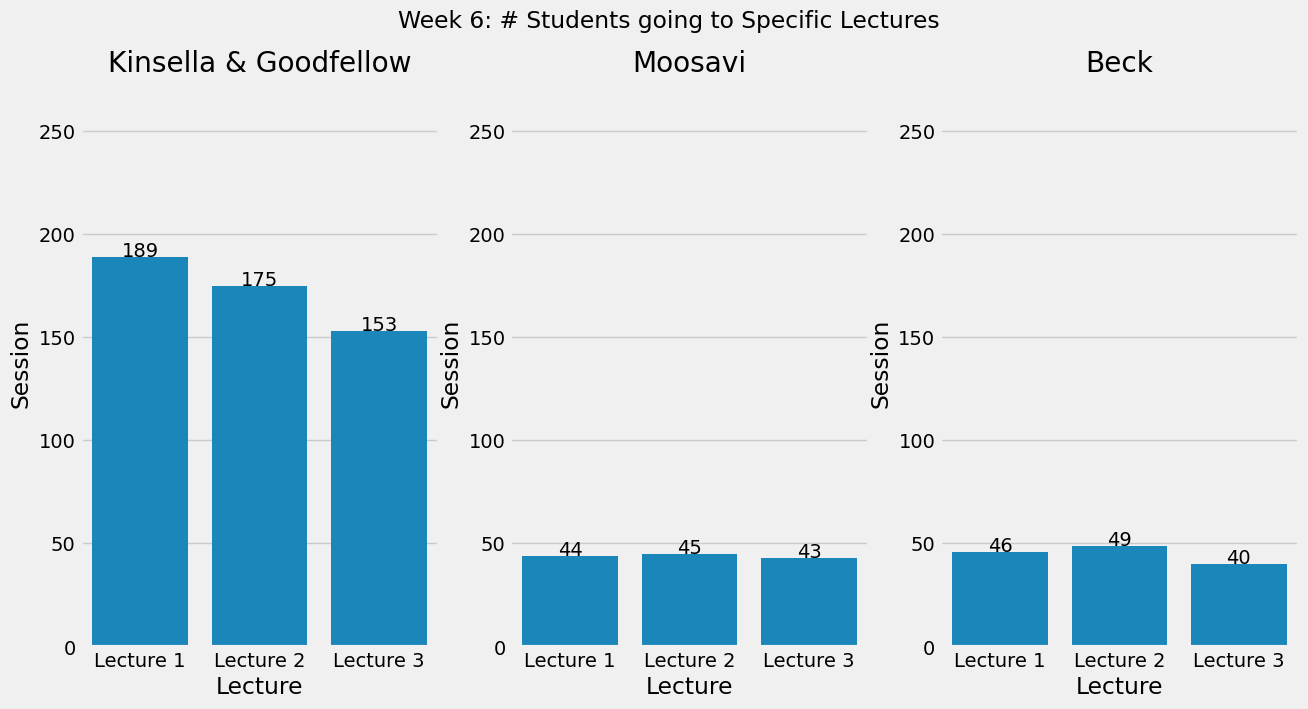

In [37]:
# figure out which specific sections students are going to 
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: # Students going to Specific Lectures".format(week))

for index, lec in enumerate(lectures):
    
    session_count = []

    # define a count for each individual session
    for session in lecture:
        count = combined_df['lecture_sections'].str.contains(session) & combined_df['lecture_sections'].str.contains(lectures[index])
        count = count.sum()
        session_count.append(count)

    # convert list to dataframe
    df = pd.DataFrame({'Lecture': lecture, 
                       'Session': session_count})

    # create the barplot
    sns.barplot(x='Lecture', y='Session', data=df, ax=axs[index])
    axs[index].set_ylim(0,275)
    axs[index].set_title(lecture_name[lecture_list[index]])

    values = list(df['Session'])

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}".format(round((values[i]),2)),ha="center")

plt.show()

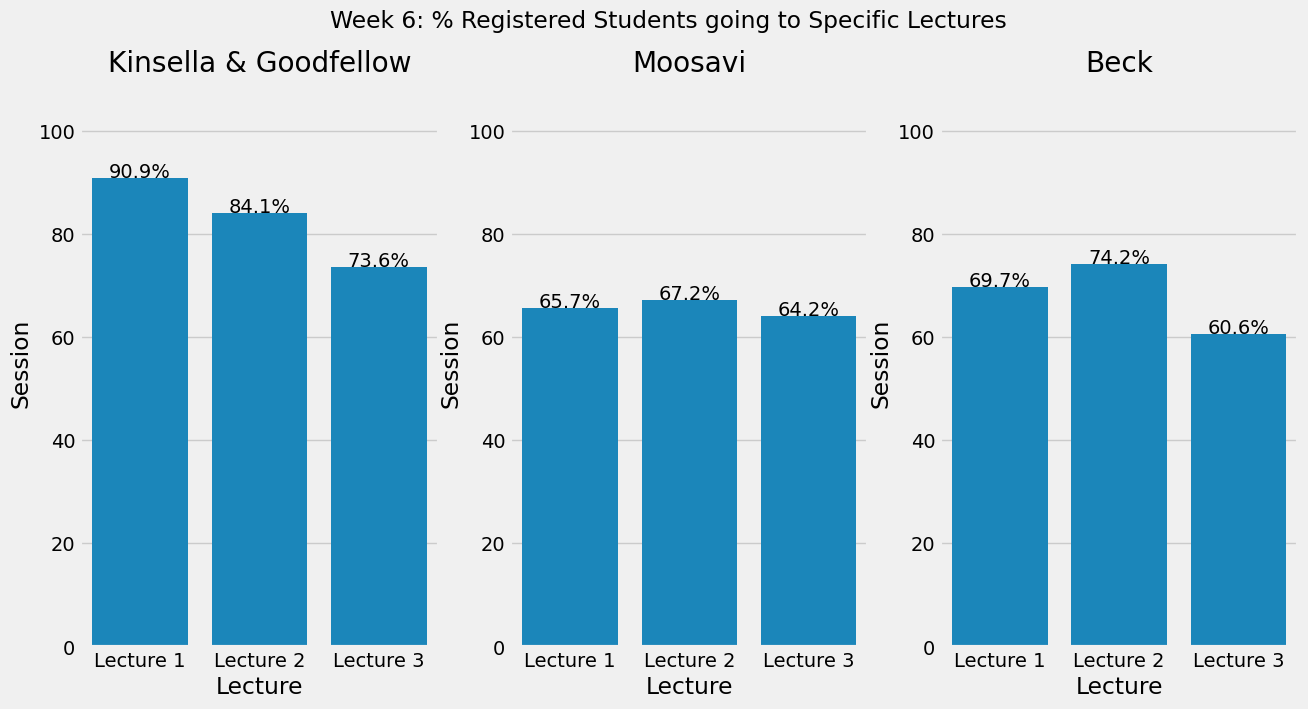

In [38]:
# figure out which specific sections students are going to 
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: % Registered Students going to Specific Lectures".format(week))

# number students registered per section
combined_df = combined_df.sort_values(by='Lecture')

for index, lec in enumerate(lectures):
    
    session_count = []

    # define a count for each individual session
    for session in lecture:
        count = combined_df['lecture_sections'].str.contains(session) & combined_df['lecture_sections'].str.contains(lectures[index])
        count = count.sum()
        session_count.append(count)

    # total number students registered in section
    registered = combined_df['Lecture'].str.contains(section[index]).sum()

    # update session count to be a percent
    session_count = [x/registered*100 for x in session_count]

    # convert list to dataframe
    df = pd.DataFrame({'Lecture': lecture, 
                       'Session': session_count})

    # create the barplot
    sns.barplot(x='Lecture', y='Session', data=df, ax=axs[index])
    axs[index].set_ylim(0,110)
    axs[index].set_title(lecture_name[lecture_list[index]])

    values = list(df['Session'])

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round((values[i]),1)),ha="center")

plt.show()

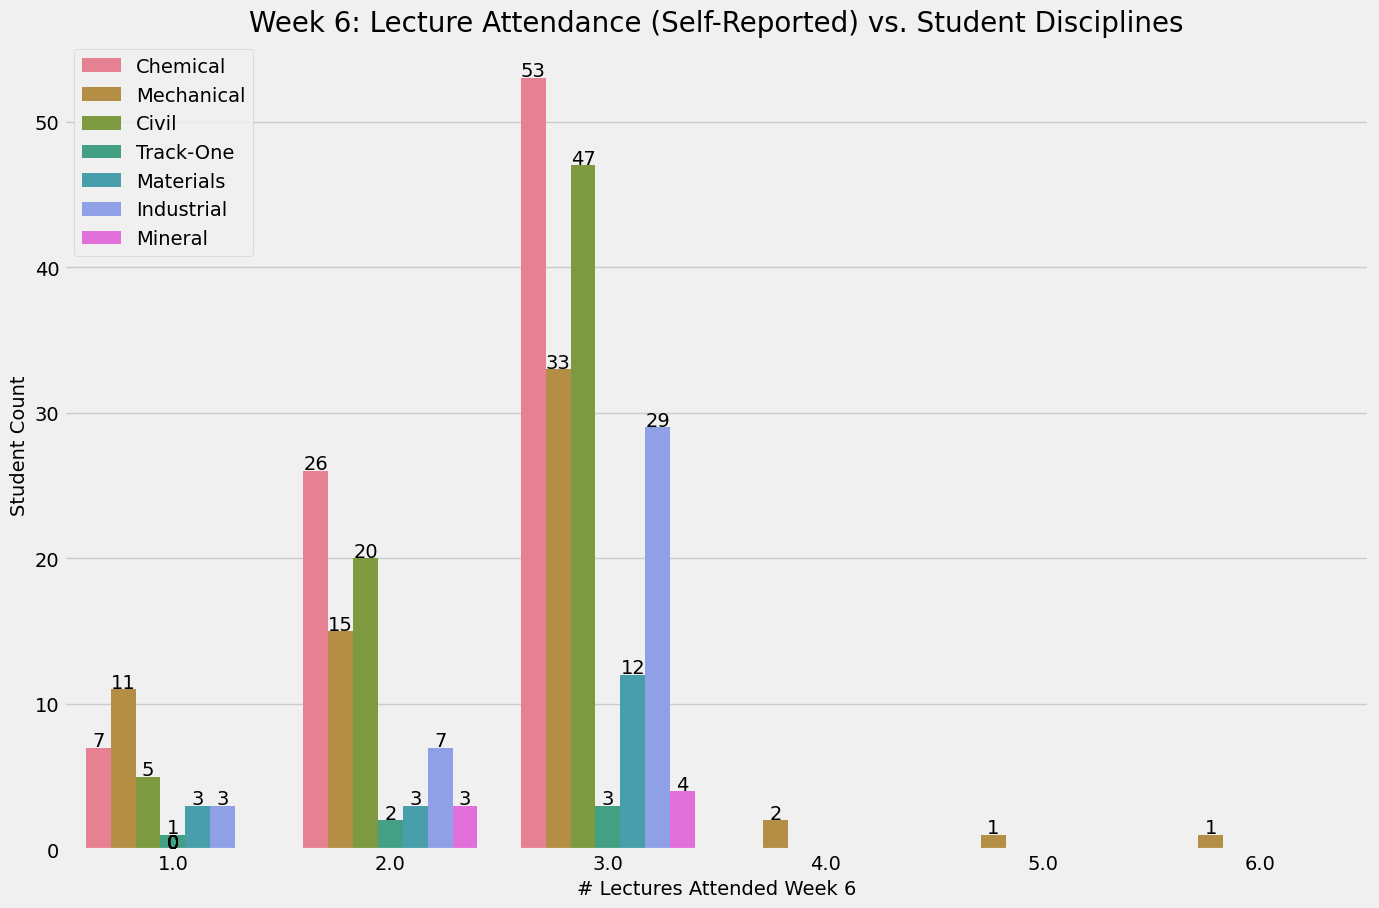

In [39]:
plt.figure(figsize=(15,10)) 
plt.title('Week {}: Lecture Attendance (Self-Reported) vs. Student Disciplines'.format(week), fontsize = 20)
ax = sns.countplot(x="lecture_count", hue="discipline", data=combined_df[combined_df['lecture_count']!=0]) 

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,"{}".format(str(p).split(',')[3].split('=')[1]),ha="center")

ax.set_ylabel('Student Count', fontsize=14)
ax.set_xlabel('# Lectures Attended Week {}'.format(week), fontsize=14)
plt.legend(loc='upper left')
plt.show()

One note: these percentages are based on the students who **answered the survey!**

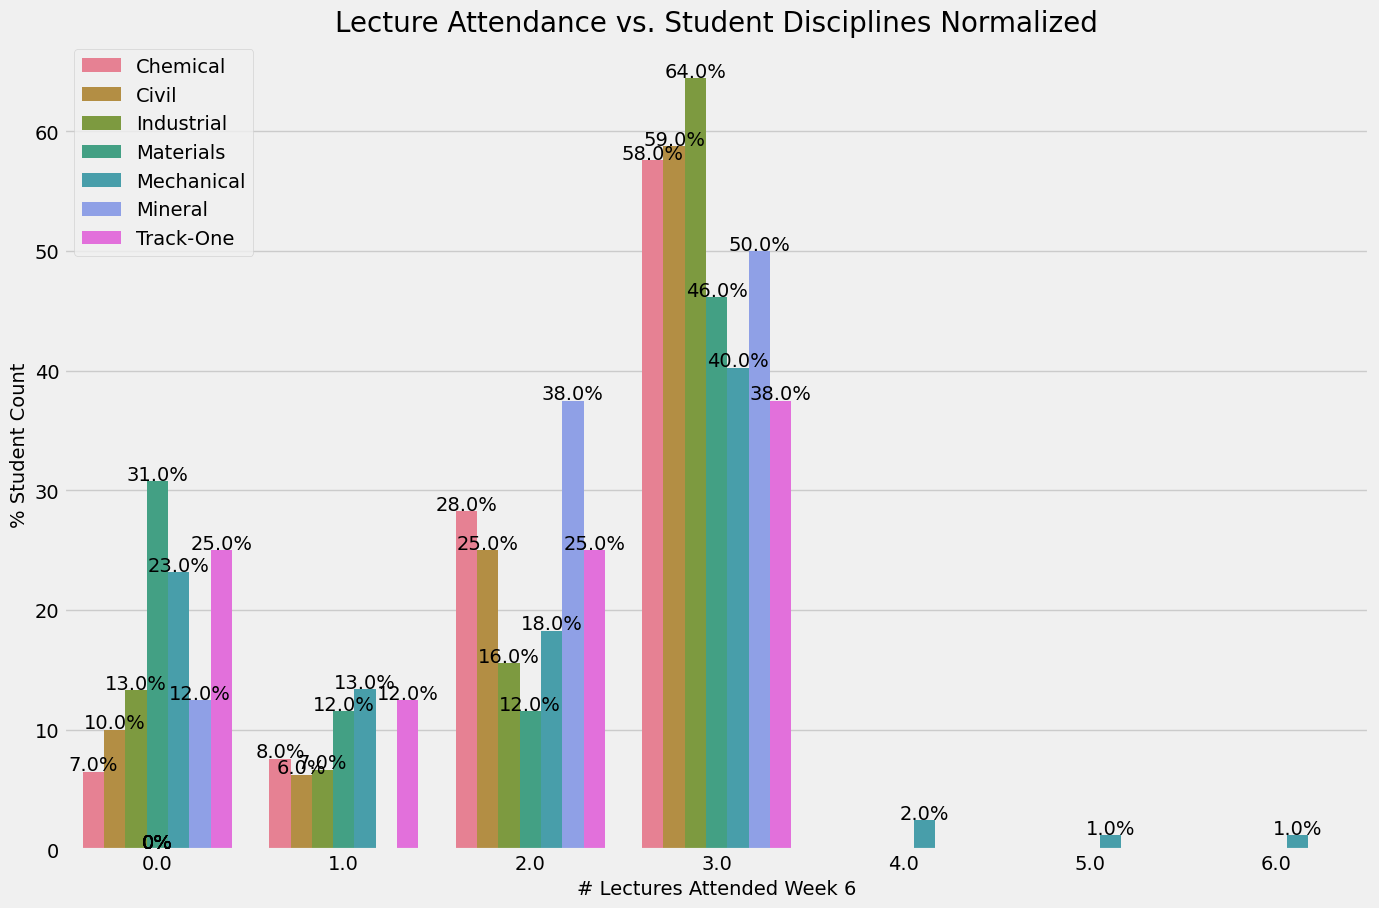

In [40]:
#define the total counts per discipline
total_students = dict(combined_df['discipline'].value_counts())

#define separate dataframe based on student discipline + attendance counts
agg_students = combined_df.groupby(['discipline','lecture_count']).count()
agg_students = agg_students.reset_index()
agg_students =  agg_students[["discipline","lecture_count","section"]].copy()

agg_students['total_count'] = agg_students['discipline'].map(total_students)
agg_students['percent'] = agg_students['section'] / agg_students['total_count'] * 100  

plt.figure(figsize=(15,10)) 
plt.title('Lecture Attendance vs. Student Disciplines Normalized', fontsize = 20)
ax = sns.barplot(x="lecture_count", y="percent", hue="discipline", data=agg_students) 

# add labels
for i, p in enumerate(ax.patches):
    height = p.get_height() 
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round(height,0)),ha="center")

ax.set_ylabel('% Student Count', fontsize=14)
ax.set_xlabel('# Lectures Attended Week {}'.format(week), fontsize=14)

plt.legend(loc='upper left')

plt.show()

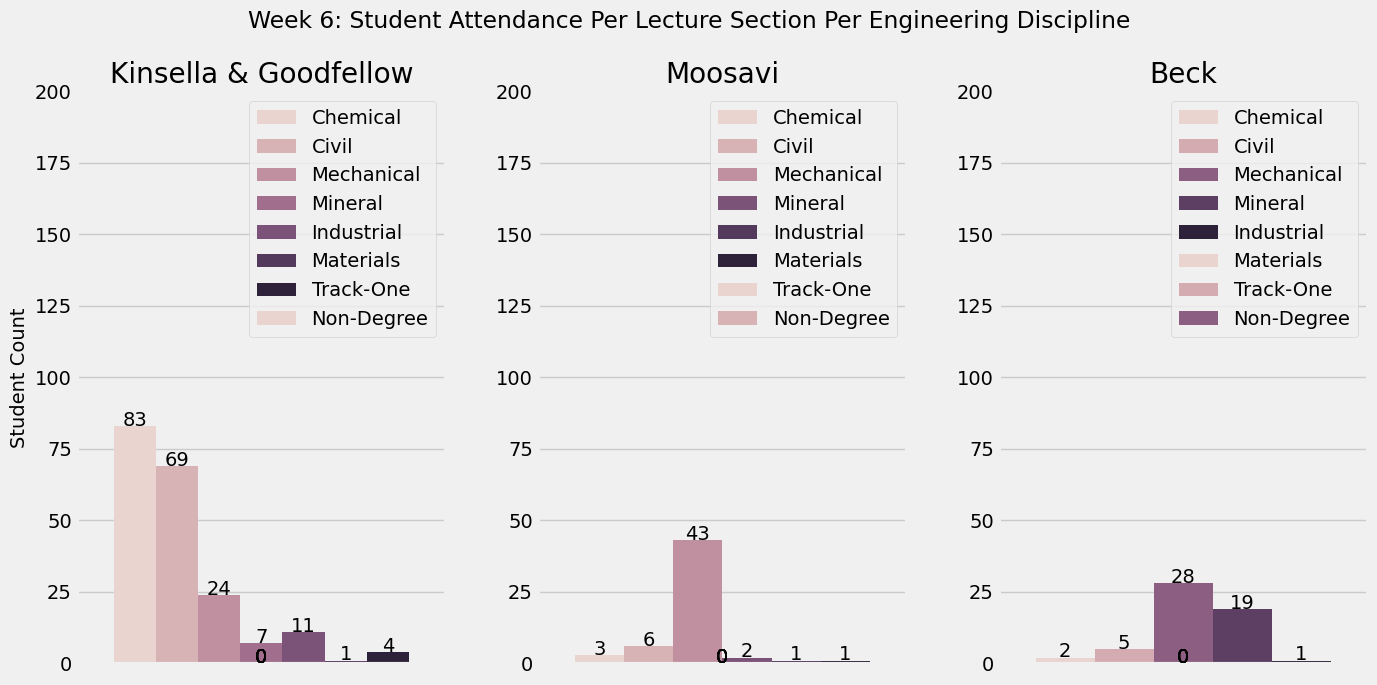

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: Student Attendance Per Lecture Section Per Engineering Discipline".format(week))

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

# convert discipline columns to numeric (so consistent between lecture sections)
disciplines_num = {
    "Chemical":1,
    "Civil":2,
    "Mechanical":3,
    "Mineral":4,
    "Industrial":5,
    "Materials":6,
    "Track-One":7, 
    "Non-Degree":8
    }

combined_df['discipline_num'] = combined_df['discipline'].map(disciplines_num) 

for index, value in enumerate(column_list):
    sns.countplot(x=value, hue="discipline_num", data=combined_df[combined_df[value]==lecture_list[index]], ax=axs[index])
    axs[index].get_xaxis().set_visible(False)
    axs[index].set_ylim(0,200)
    axs[index].set_title(lecture_name[lecture_list[index]])
    axs[index].legend(labels = list(disciplines_num.keys()))

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}".format(str(p).split(',')[3].split('=')[1][0:4]),ha="center")

    if index == 0:
        axs[index].set_ylabel('Student Count', fontsize=14)
    else: 
        axs[index].set_ylabel(' ')

# Rotating x-axis labels for each subplot
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()
plt.show()

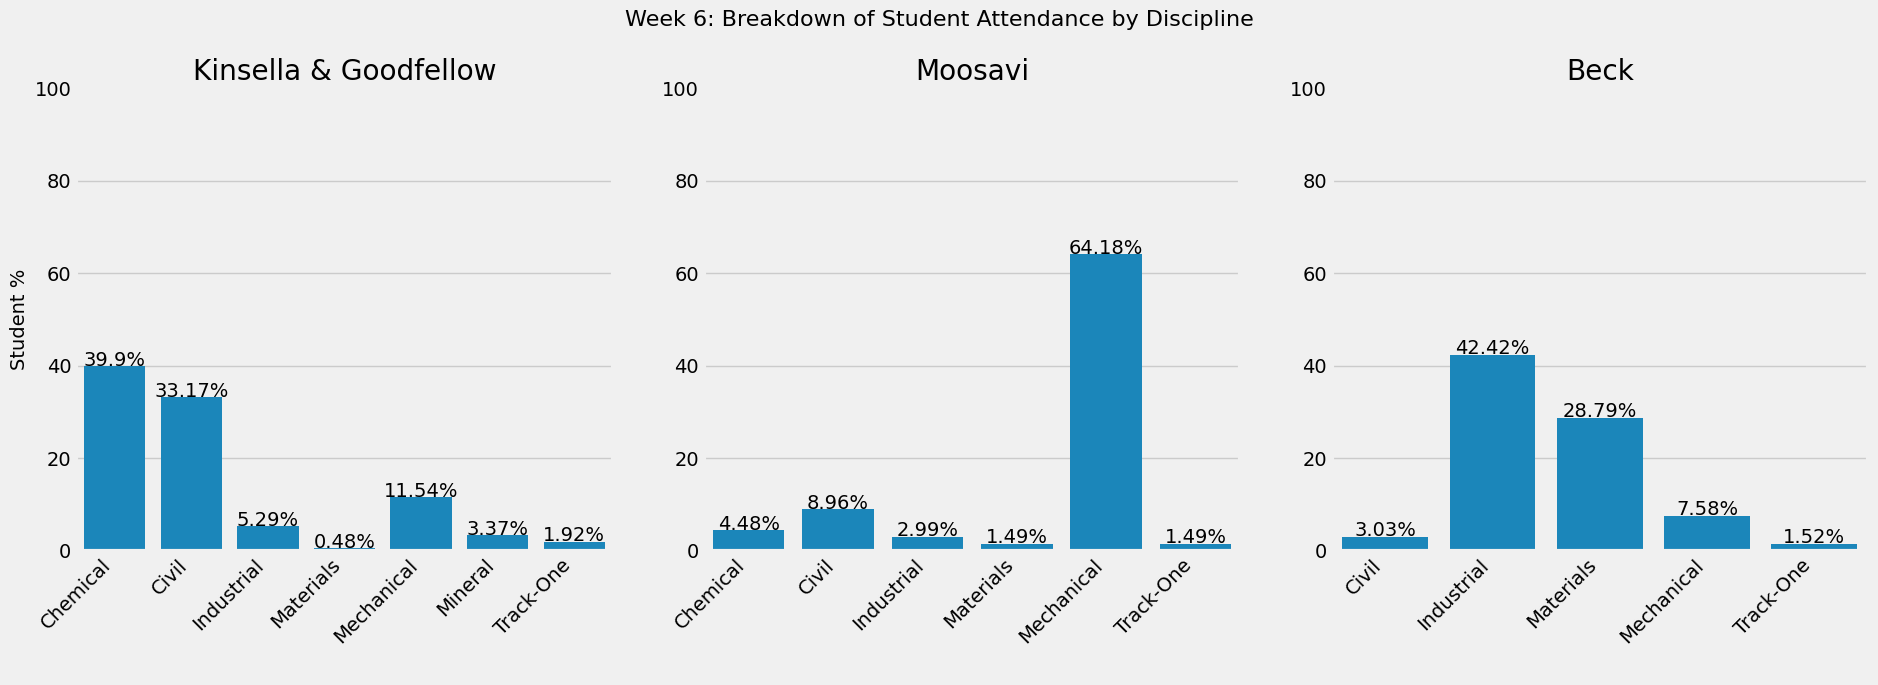

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(19, 7))

fig.suptitle("Week {}: Breakdown of Student Attendance by Discipline".format(week), size =16)

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

assigned_lecture = [
    len(combined_df[combined_df["Lecture"]=="LEC0101"]),
    len(combined_df[combined_df["Lecture"]=="LEC0102"]),
    len(combined_df[combined_df["Lecture"]=="LEC0103"])
]

for index, value in enumerate(column_list):

    #filter down the dataframe only to the specific lecturer
    df_temp = combined_df[combined_df[value]==lecture_list[index]]
    df_temp = df_temp.groupby("discipline").agg('count')

    df_temp =  df_temp[["section"]].copy().reset_index()
    df_temp['percent'] = df_temp['section'] / assigned_lecture[index] * 100


    sns.barplot(data=df_temp, x="discipline", y="percent", ax=axs[index])
    axs[index].set_ylim(0,100)
    axs[index].set_title(lecture_name[lecture_list[index]])

    values = list(df_temp['percent'])

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round((values[i]),2)),ha="center")
    
    axs[index].set_xlabel(' ')
    if index == 0:
        axs[index].set_ylabel('Student %', fontsize=14)
    else: 
        axs[index].set_ylabel(' ')

# Rotating x-axis labels for each subplot
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()
plt.show()

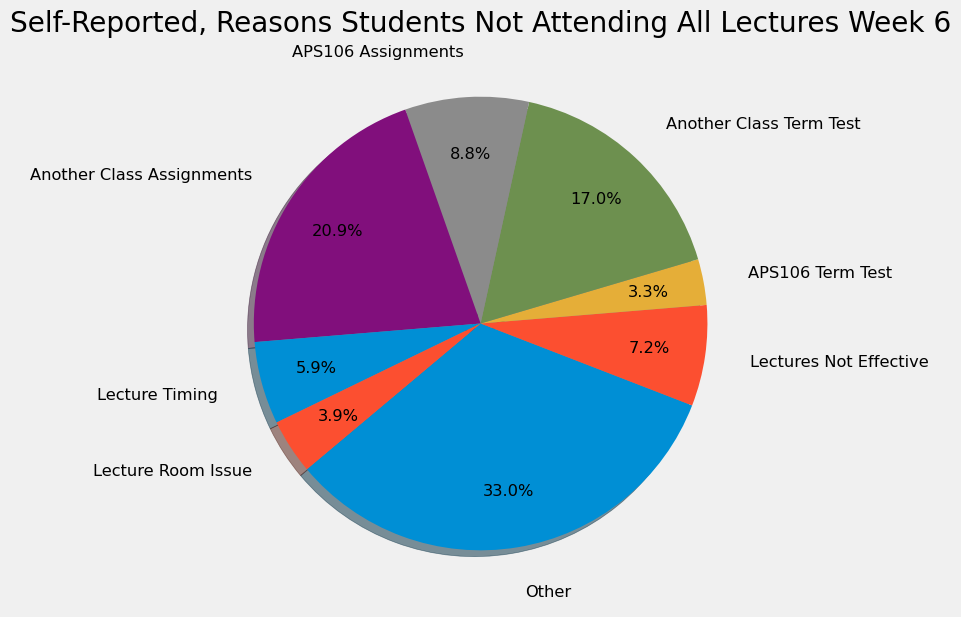

In [43]:
# reason students not going to assigned lecture section
q2_values = {
    'Other':'Other',
    'The lectures are not an effective learning tool for me':'Lectures Not Effective',
    'I was studying for a term test for this course':'APS106 Term Test',
    'I was studying for a term test for another course':'Another Class Term Test',
    'I was working on assignments for this course':'APS106 Assignments',
    'I was working on assignments and/or projects for another course':'Another Class Assignments',
    'The lecture times make them challenging to regularly attend':'Lecture Timing',
    'The lecture room is not conducive to learning':'Lecture Room Issue'
}

q2_counts = []

for key, value in q2_values.items():
    count = combined_df['lecture_reasons'].str.contains(key)
    count = count.sum()
    q2_counts.append(count)


plt.figure(figsize=(7,7)) 
plt.title("Self-Reported, Reasons Students Not Attending All Lectures Week {}".format(week))

plt.pie(q2_counts, labels=q2_values.values(), startangle=-140,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.20)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  

plt.show()

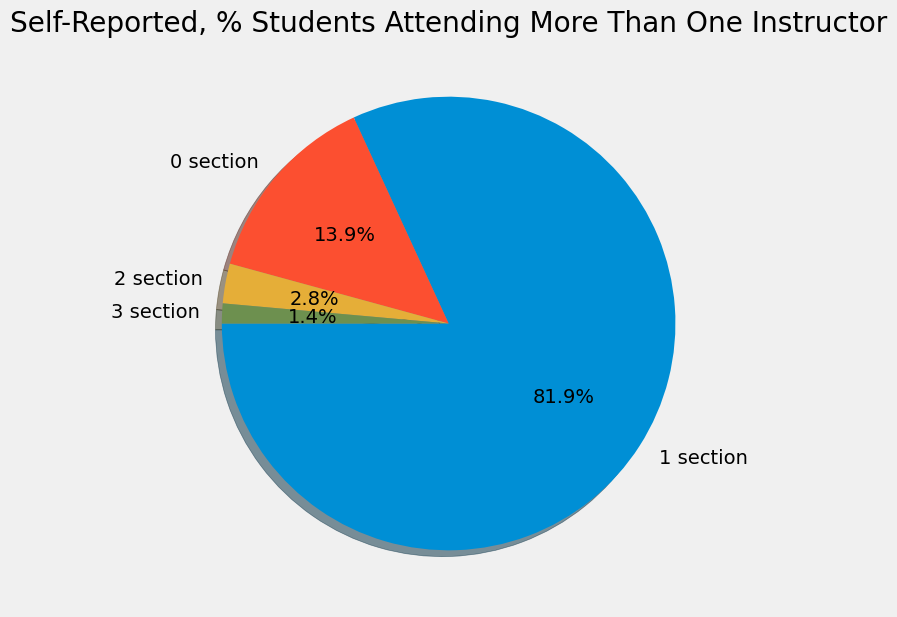

In [44]:
# how many students attended more than one instructor session last week (i.e. both Kinsella and Beck lectures)
plt.figure(figsize=(7,7)) 
plt.title("Self-Reported, % Students Attending More Than One Instructor")

# combined_df['multiple_sections'] = combined_df['lecture_sections'].str.contains(",")
combined_df['multiple_sections'] = combined_df[['LEC0101_attended', 'LEC0102_attended', 
                                                'LEC0103_attended']].applymap(lambda x: isinstance(x, str) and x != 'False').sum(axis=1)


combined_df = combined_df.sort_values(by='multiple_sections')
name = ["{} section".format(x) for x in combined_df['multiple_sections'].value_counts().keys()]
values = combined_df['multiple_sections'].value_counts()

plt.pie(values, labels=name, startangle=-180,autopct='%1.1f%%', shadow=True)
plt.show()

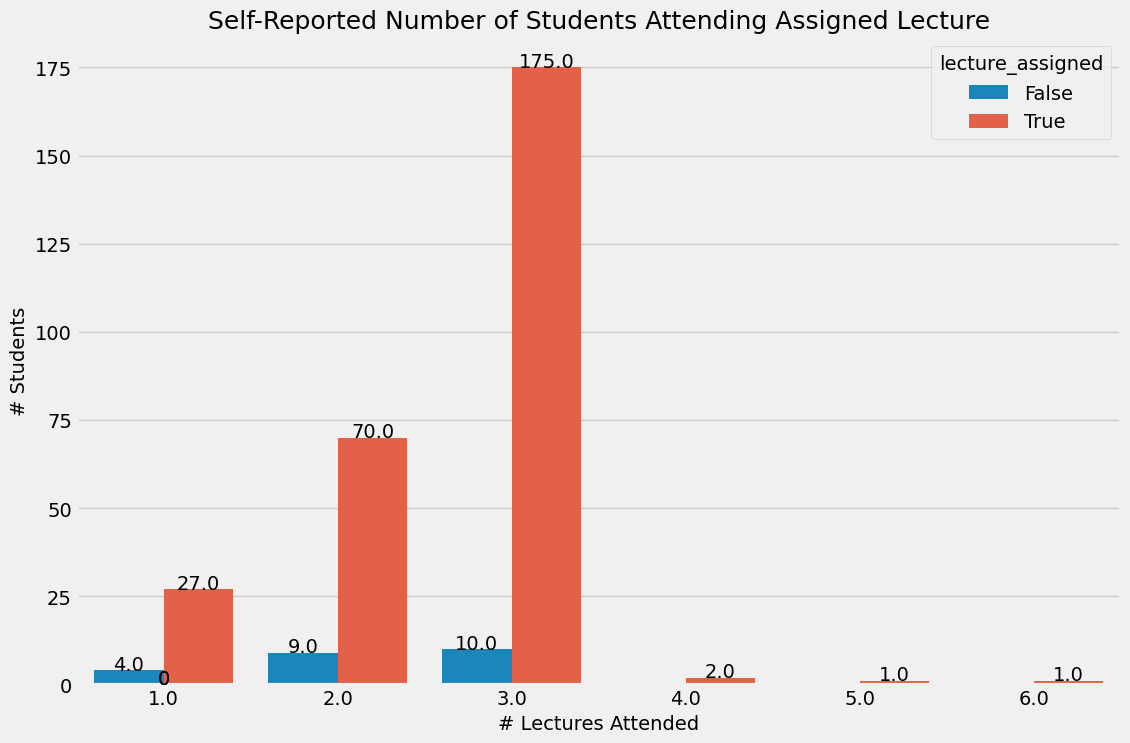

In [45]:
# how many students are not attending their assigned lecture section?
plt.figure(figsize=(12,8)) 

plt.title('Self-Reported Number of Students Attending Assigned Lecture', fontsize = 18)
ax = sns.countplot(x="lecture_count", hue="lecture_assigned", data=combined_df[combined_df['lecture_count']>0]) 

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, height ,ha="center")

ax.set_xlabel('# Lectures Attended', fontsize=14)
ax.set_ylabel('# Students', fontsize=14)

plt.show()

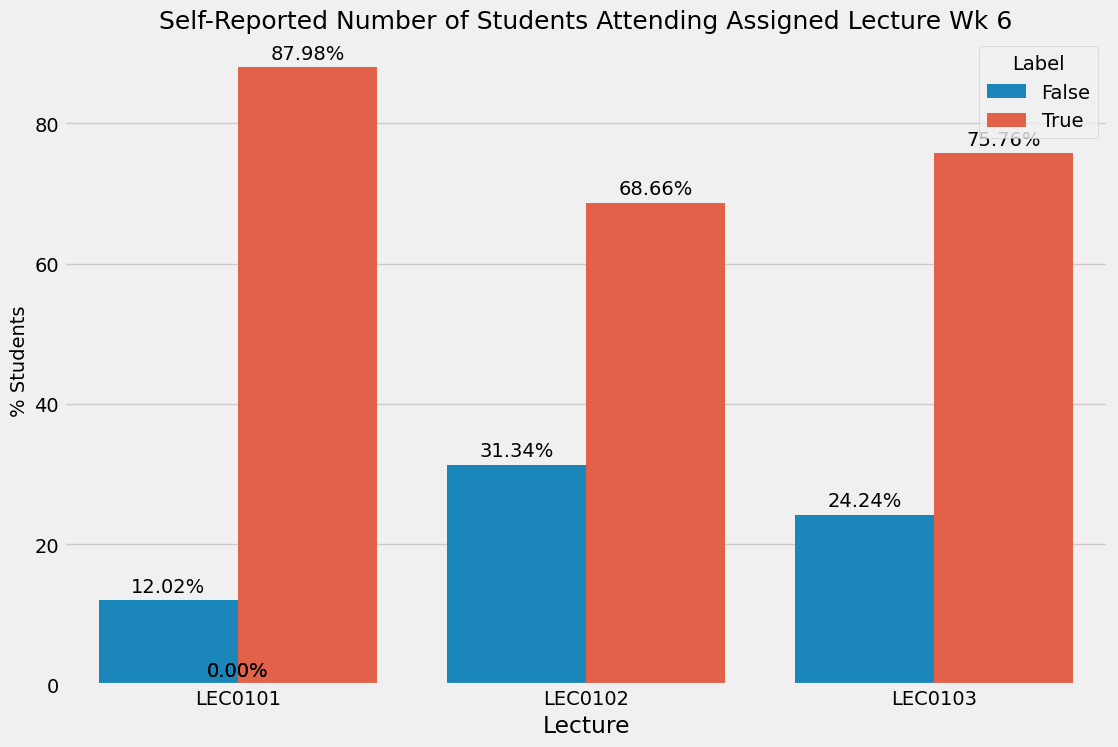

In [46]:
# how many students are not attending their assigned lecture section?
plt.figure(figsize=(12,8)) 

plt.title('Self-Reported Number of Students Attending Assigned Lecture Wk {}'.format(week), fontsize = 18)
combined_df['lecture_name_assigned'] = combined_df['Lecture'].map(lecture_name) 

lectures = []
counts = []
labels = []

# need to loop through each lecture, generate a new dataframe
for lecture in lecture_name:
    temp_df = combined_df[combined_df['Lecture']==lecture]
    total = len(temp_df)
    counts.append(len(temp_df[temp_df['lecture_assigned']==True]) / total*100)
    counts.append(len(temp_df[temp_df['lecture_assigned']==False]) / total*100)
    labels.append(True)
    labels.append(False)
    lectures.append(lecture)
    lectures.append(lecture)


lecture_df = pd.DataFrame({'Lecture':lectures,'Assigned Lecture':counts,'Label':labels})

ax = sns.barplot(x="Lecture", y = 'Assigned Lecture', hue="Label", data=lecture_df) 

# ax.set_xlabel('Total Students Present per Lecture Section', fontsize=14)
ax.set_ylabel('% Students', fontsize=14)

# Annotate each bar with its value, rounded to two decimal places
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

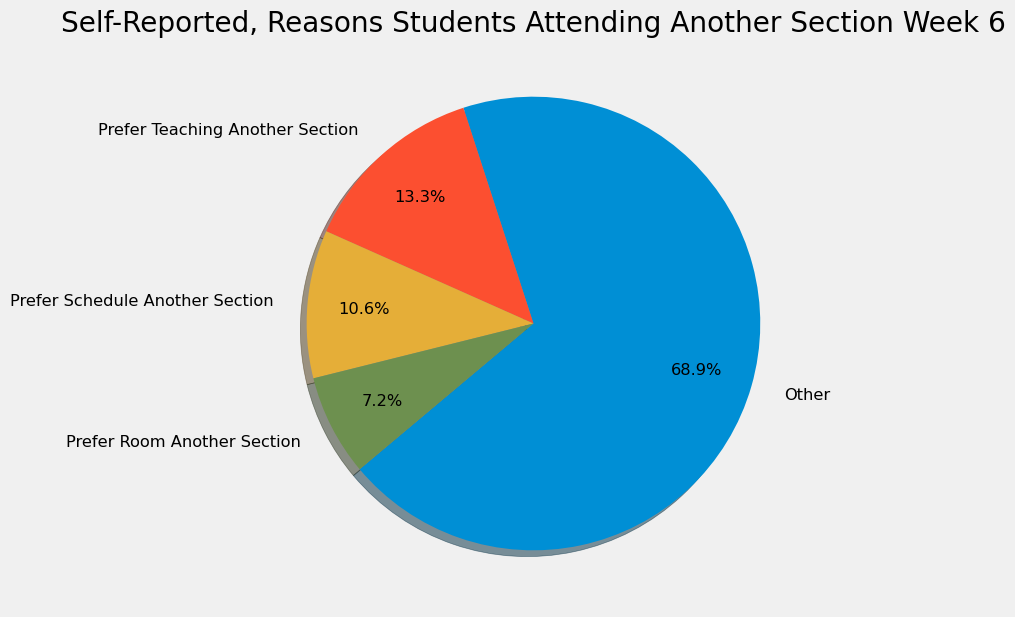

In [47]:
# reasons students not going to assigned lecture
q3_values = {
    'Other':'Other',
    'teaching style': 'Prefer Teaching Another Section',
    'scheduling': 'Prefer Schedule Another Section',
    'room': 'Prefer Room Another Section'
}


q3_counts = []

for key, value in q3_values.items():
    count = combined_df['lecture_alternate_section'].str.contains(key)
    count = count.sum()
    q3_counts.append(count)


plt.figure(figsize=(7,7)) 
plt.title("Self-Reported, Reasons Students Attending Another Section Week {}".format(week))

plt.pie(q3_counts, labels=q3_values.values(), startangle=-140,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.15)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

# Hybrid Learning, Online Materials Use

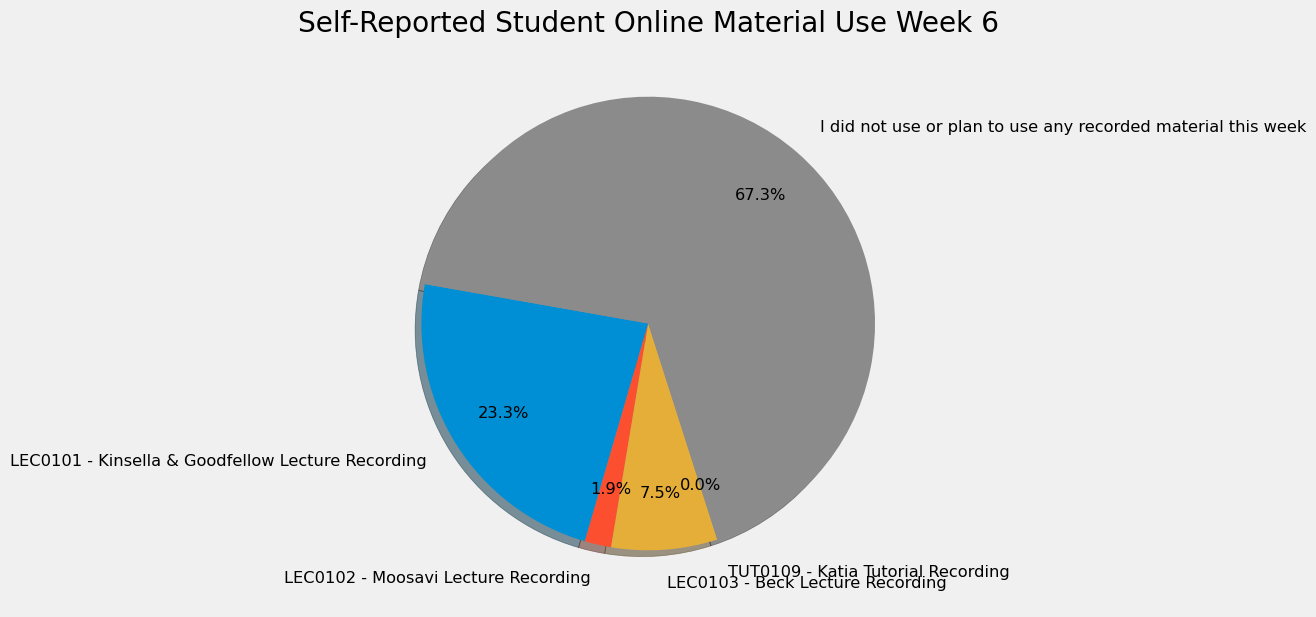

In [48]:
# which video materials are people using?
online_values = [
    'LEC0101 - Kinsella & Goodfellow Lecture Recording',
    'LEC0102 - Moosavi Lecture Recording',
    'LEC0103 - Beck Lecture Recording',
    'TUT0109 - Katia Tutorial Recording',
    'I did not use or plan to use any recorded material this week'
]

online_count = []

for value in online_values:
    count = combined_df['video_materials'].str.contains(value)
    count = count.sum()
    online_count.append(count)

plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Student Online Material Use Week {}".format(week))

plt.pie(online_count, labels=online_values, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.15)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

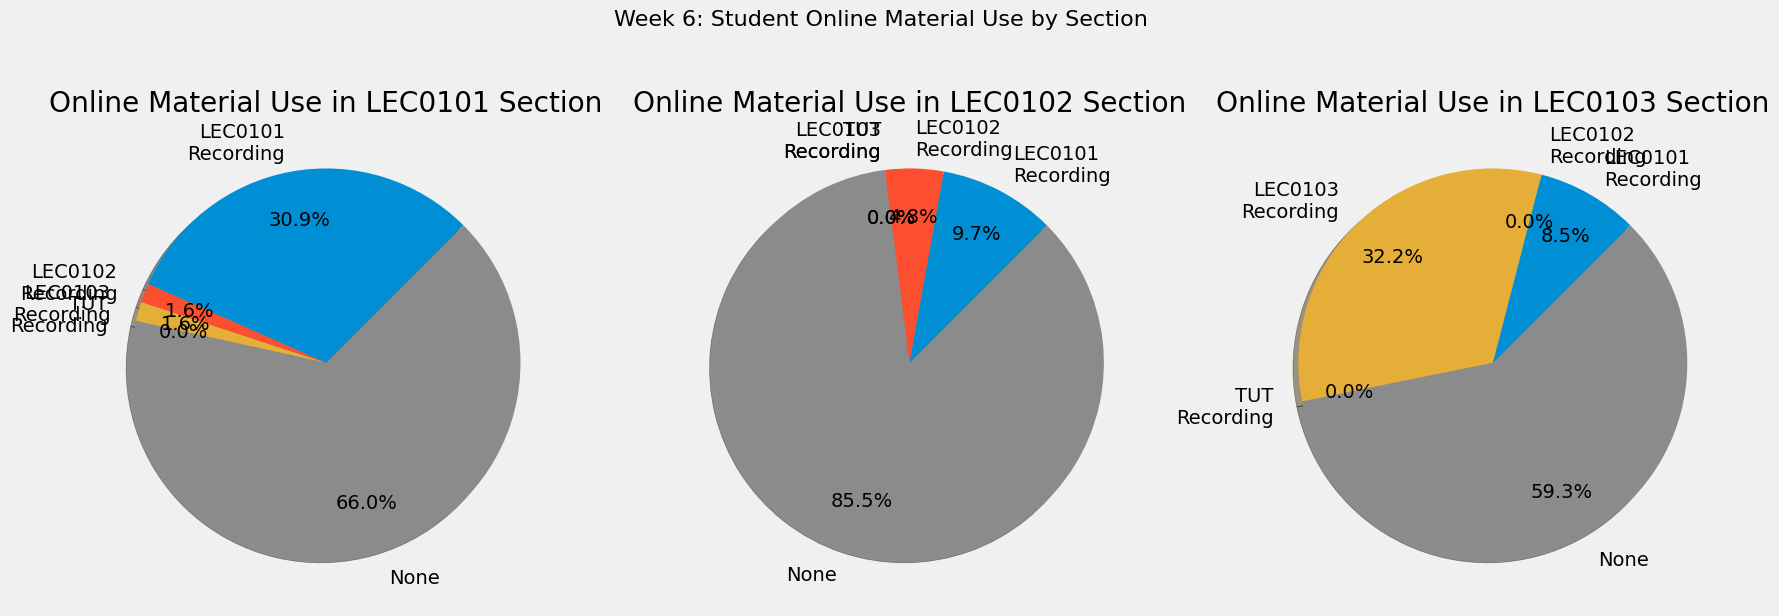

In [49]:
# which video materials are people using per lecture section

fig, axs = plt.subplots(1, 3, figsize=(19, 7))

fig.suptitle("Week {}: Student Online Material Use by Section".format(week), size =16)

# which video materials are people using?
online_values = [
    'LEC0101 - Kinsella & Goodfellow Lecture Recording',
    'LEC0102 - Moosavi Lecture Recording',
    'LEC0103 - Beck Lecture Recording',
    'TUT0109 - Katia Tutorial Recording',
    'I did not use or plan to use any recorded material this week'
]

online_labels = [
    'LEC0101\nRecording',
    'LEC0102\nRecording',
    'LEC0103\nRecording',
    'TUT\nRecording',
    'None'
]

lecture_sections = ['LEC0101', 'LEC0102', 'LEC0103']

for index, lecture in enumerate(lecture_sections): # we will check against assigned lecture sections

    temp_df = combined_df[combined_df['Lecture']==lecture]

    online_count = []

    for value in online_values:
        count = temp_df['video_materials'].str.contains(value)
        count = count.sum()
        online_count.append(count)

    axs[index].pie(online_count, labels = online_labels, autopct='%1.1f%%', shadow=True, startangle=45,pctdistance=0.75, labeldistance=1.15)
    axs[index].title.set_text("Online Material Use in {} Section".format(str(lecture_list[index])))
  
plt.show()

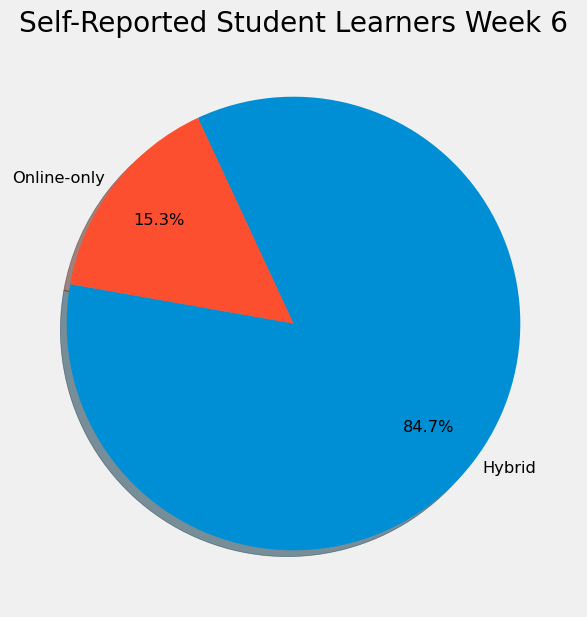

In [50]:
# how many people using video materials also attended lectures in-person
combined_df['lecture_count'] = combined_df['lecture_count'].fillna(0)

# create a column, which will have the values online-only, in-person only or hybrid learner, or no engagement in a given week
combined_df['learner_style'] = np.where(
    (combined_df['video_materials'] != 'None') & (combined_df['lecture_count'] != 0), 'Hybrid',
    np.where(
        (combined_df['video_materials'] == 'None') & (combined_df['lecture_count'] != 0), 'In-Person',
        np.where(
            (combined_df['video_materials'] != 'None') & (combined_df['lecture_count'] == 0), 'Online-only',
            'No engagement this week'
        )
    )
)

plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Student Learners Week {}".format(week))

values = dict(combined_df['learner_style'].value_counts()).values()
labels = dict(combined_df['learner_style'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

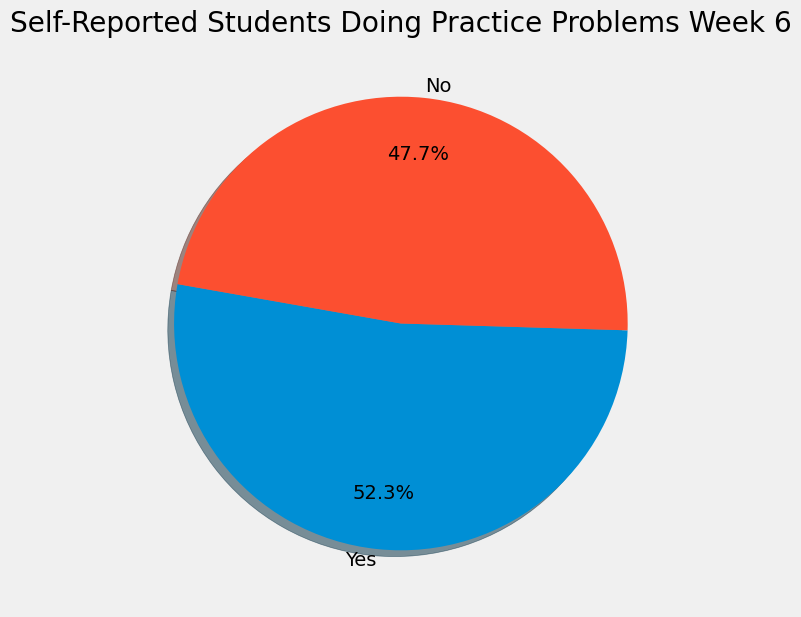

In [51]:
# practice problems
plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Students Doing Practice Problems Week {}".format(week))

values = dict(combined_df['practice_problems'].value_counts()).values()
labels = dict(combined_df['practice_problems'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

plt.show()

# Tutorials

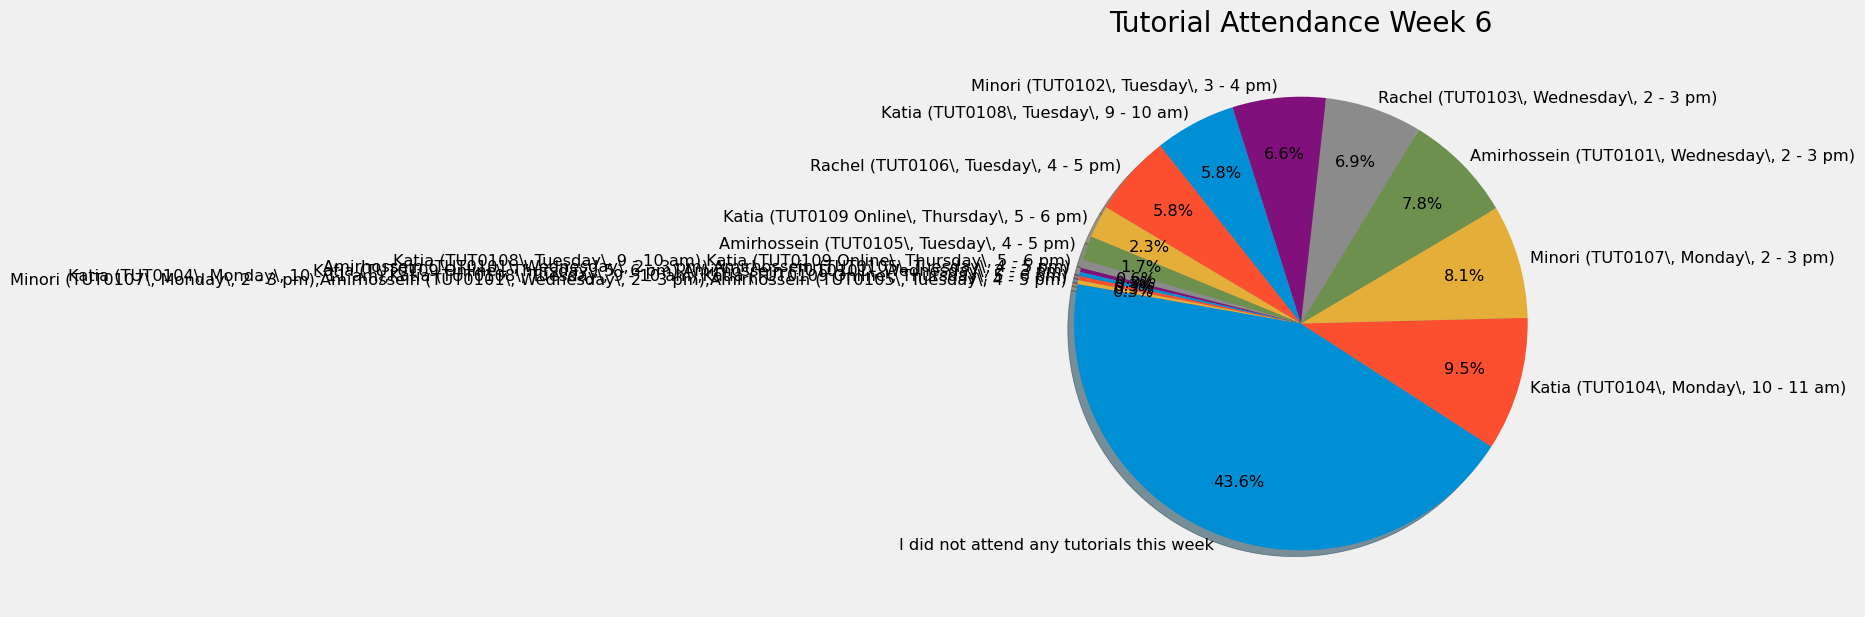

In [52]:
plt.figure(figsize=(7,7)) 
plt.title("Tutorial Attendance Week {}".format(week))

values = dict(combined_df['tutorial_sections'].value_counts()).values()
labels = dict(combined_df['tutorial_sections'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

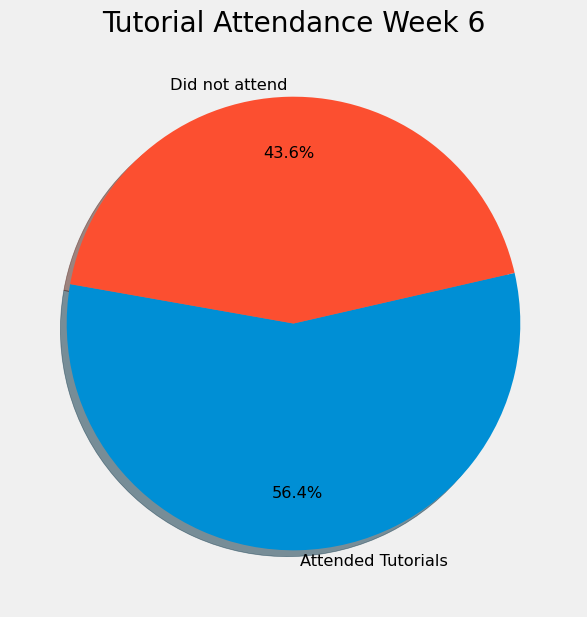

In [53]:
# can make a simpler pie chart too - 'yes'/'no' for attendance
combined_df['tutorial_bool'] = -combined_df['tutorial_sections'].str.contains('I did not attend any tutorials this week')

plt.figure(figsize=(7,7)) 
plt.title("Tutorial Attendance Week {}".format(week))

values = dict(combined_df['tutorial_bool'].value_counts()).values()
# labels = dict(combined_df['tutorial_bool'].value_counts()).keys()

labels = ['Attended Tutorials','Did not attend']

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

# Practicals

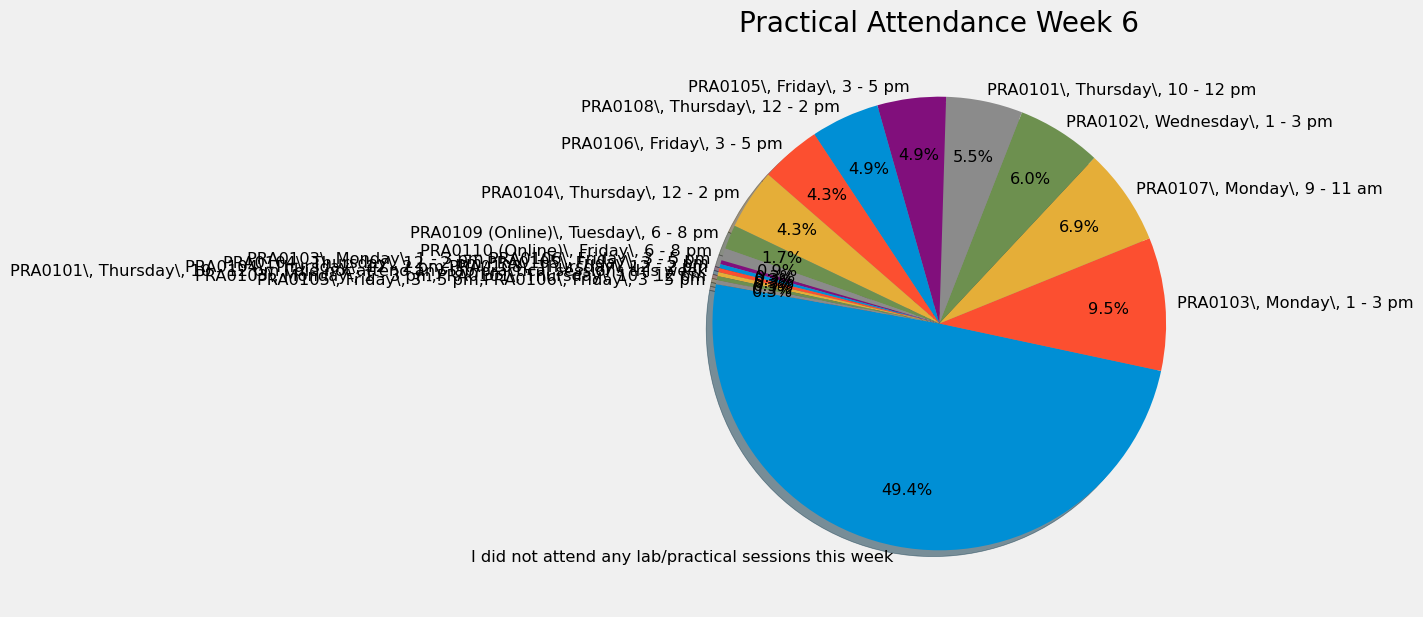

In [54]:
plt.figure(figsize=(7,7)) 
plt.title("Practical Attendance Week {}".format(week))

values = dict(combined_df['practical_sections'].value_counts()).values()
labels = dict(combined_df['practical_sections'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

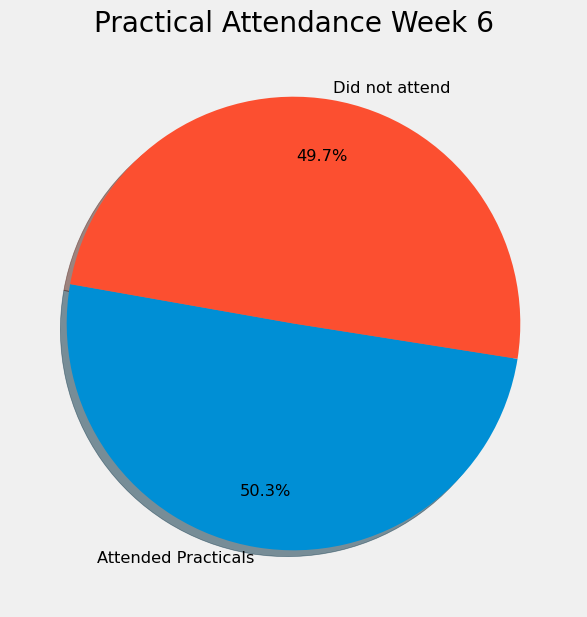

In [55]:
# can make a simpler pie chart too - 'yes'/'no' for attendance
combined_df['practical_bool'] = -combined_df['practical_sections'].str.contains('I did not attend any lab')

plt.figure(figsize=(7,7)) 
plt.title("Practical Attendance Week {}".format(week))

values = dict(combined_df['practical_bool'].value_counts()).values()
# labels = dict(combined_df['tutorial_bool'].value_counts()).keys()

labels = ['Attended Practicals','Did not attend']

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

# Individual Topics Covered During the Week

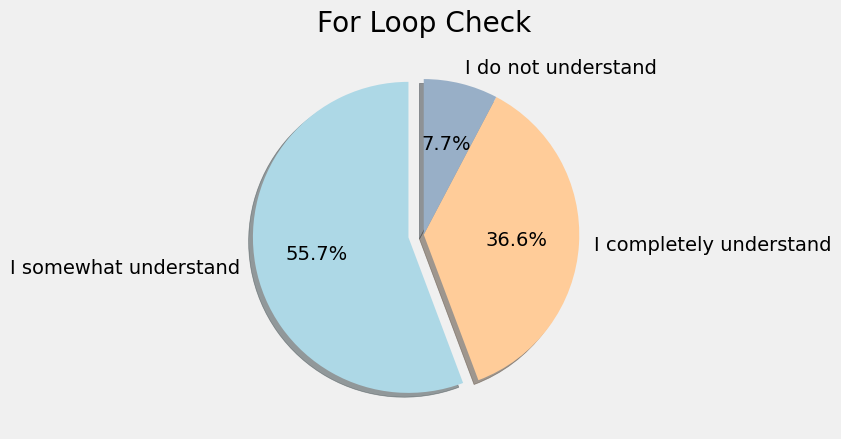

In [56]:
# check general % of students comfortable with the new topics
columns = ['for_loop_check']

for index, value in enumerate(columns): 
    column = dict(combined_df[value].value_counts())
    data = list(column.values())
    labels = list(column.keys())

    explode = (0.1, 0, 0)
    
    total = sum(data)
    data_per = data/total*100
    
    plt.pie(data_per, labels = labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=90,explode=explode)
    plt.title("For Loop Check")

plt.show()

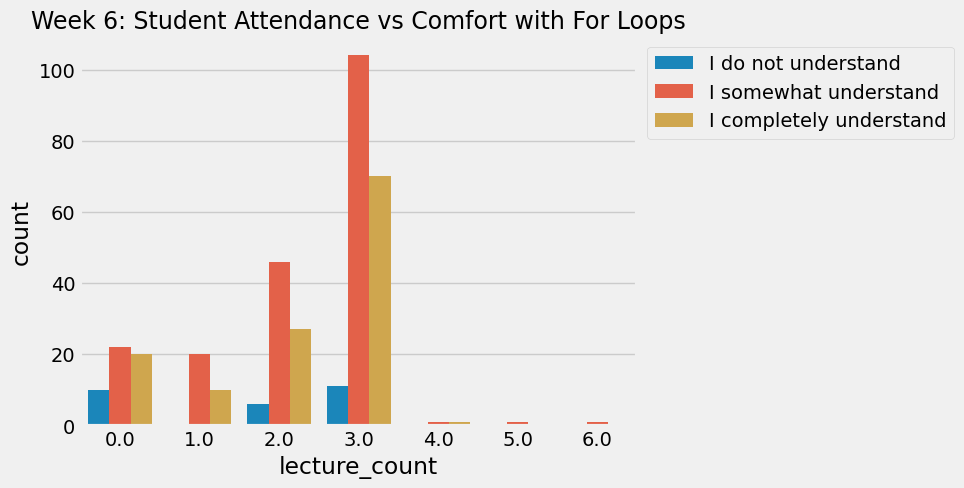

In [57]:
# comfort level correlated with attendance level

plt.title("Week {}: Student Attendance vs Comfort with For Loops".format(week), fontsize = 17)
columns = ['for_loop_check']

numeric = {
    'I do not understand': 0,
    'I somewhat understand': 1,
    'I completely understand': 2
}

new_column = [ x + '_numeric' for x in columns]

for index, value in enumerate(columns):

    combined_df[new_column[index]] = combined_df[value].map(numeric)

    sorted_df = combined_df.sort_values(by=[new_column[index]])
    sns.countplot(x="lecture_count", hue=value, data=sorted_df) 
    

# Remove legend from the first two plots and add it to the last plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

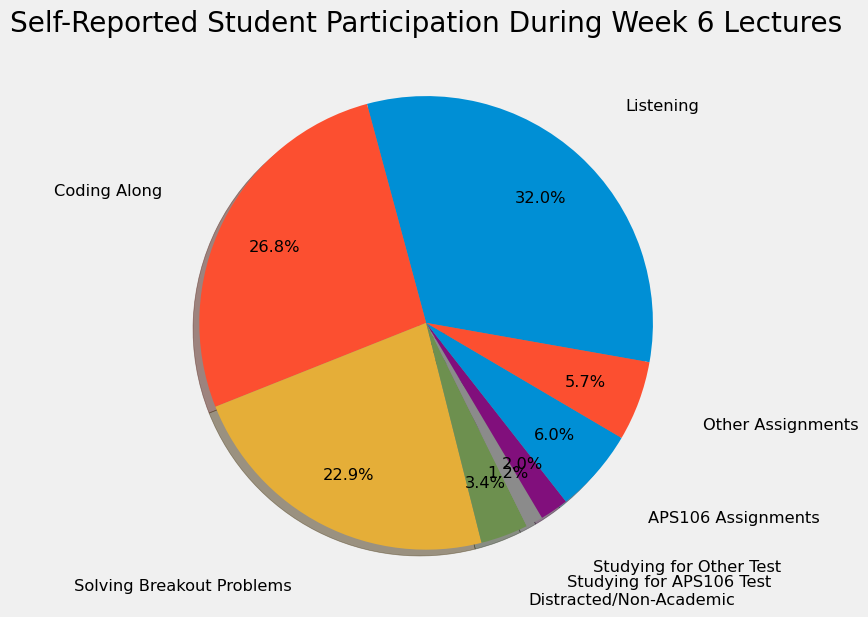

In [58]:
# what did students do in lecture during the week

q4_values = [
    'Following the lecture by looking at the content and listening to the instructor',
    'Coding along with the instructor on my device',
    'Trying to solve the breakout problems',
    'Distracted with non-academic activities',
    'I was studying for a term test for this course',
    'I was studying for a term test for another course',
    'I was working on assignments for this course',
    'I was working on assignments and/or projects for another course'
]

q4_labels = [
    'Listening',
    'Coding Along',
    'Solving Breakout Problems',
    'Distracted/Non-Academic',
    'Studying for APS106 Test',
    'Studying for Other Test',
    'APS106 Assignments',
    'Other Assignments'
]

q4_counts = []

for value in q4_values:
    count = combined_df['hybrid_learning'].str.contains(value)
    count = count.sum()
    q4_counts.append(count)

for index, value in enumerate(q4_counts):
    if value == 0:
        q4_counts.remove(0)
        q4_values.pop(index)
        q4_labels.pop(index)

plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Student Participation During Week {} Lectures".format(week))

plt.pie(q4_counts, labels=q4_labels, startangle=-10,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.30)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

# Student Course Progress Check

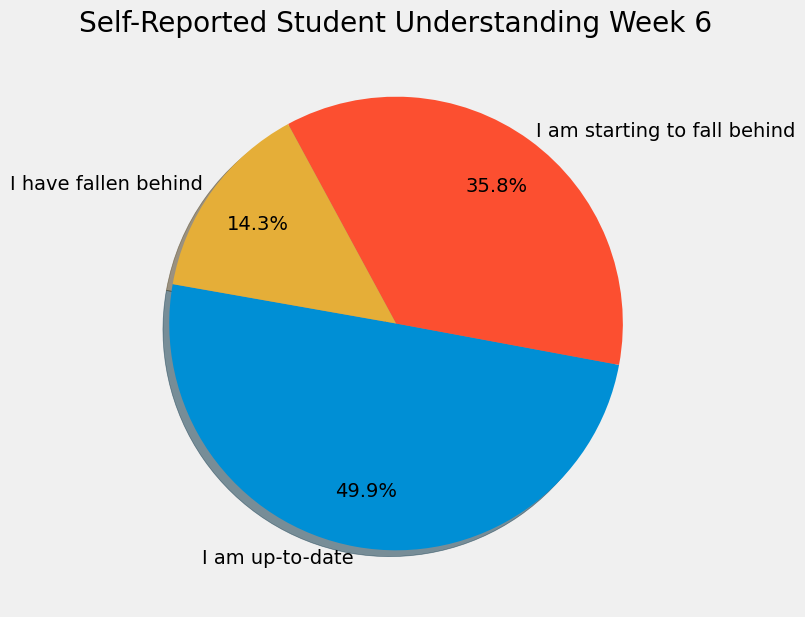

In [59]:
# are students feeling up to date or behind

plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Student Understanding Week {}".format(week))

values = dict(combined_df['progress_check'].value_counts()).values()
labels = dict(combined_df['progress_check'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

plt.show()

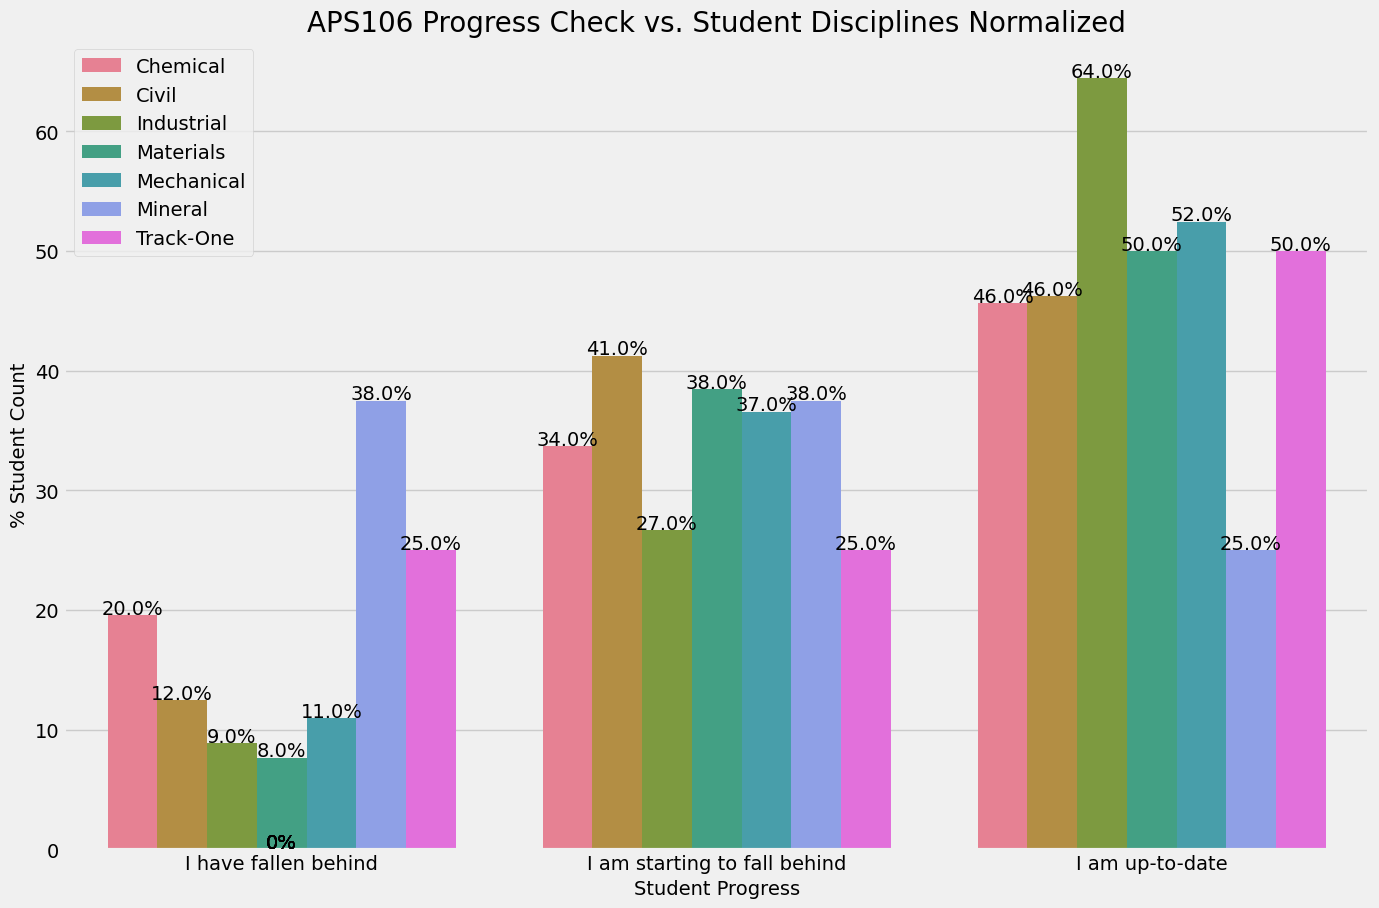

In [60]:
#define the total counts per discipline
total_students = dict(combined_df['discipline'].value_counts())

#define separate dataframe based on student discipline + attendance counts
agg_students = combined_df.groupby(['discipline','progress_check']).count()
agg_students = agg_students.reset_index()
agg_students =  agg_students[["discipline","progress_check","section"]].copy()
#agg_students = agg_students[agg_students['lecture_count']!=0]

agg_students['total_count'] = agg_students['discipline'].map(total_students)
agg_students['percent'] = agg_students['section'] / agg_students['total_count'] * 100  

progress_numeric = {
    'I have fallen behind': 0,
    'I am starting to fall behind': 1,
    'I am up-to-date': 2
}

agg_students['progress_numeric'] = agg_students['progress_check'].map(progress_numeric)

agg_students = agg_students.sort_values(by=['progress_numeric','discipline'])

plt.figure(figsize=(15,10)) 
plt.title('APS106 Progress Check vs. Student Disciplines Normalized', fontsize = 20)
ax = sns.barplot(x="progress_check", y="percent", hue="discipline", data=agg_students) 

# add labels
for i, p in enumerate(ax.patches):
    height = p.get_height() 
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round(height,0)),ha="center")

ax.set_ylabel('% Student Count', fontsize=14)
ax.set_xlabel('Student Progress', fontsize=14)

plt.legend(loc='upper left')

plt.show()

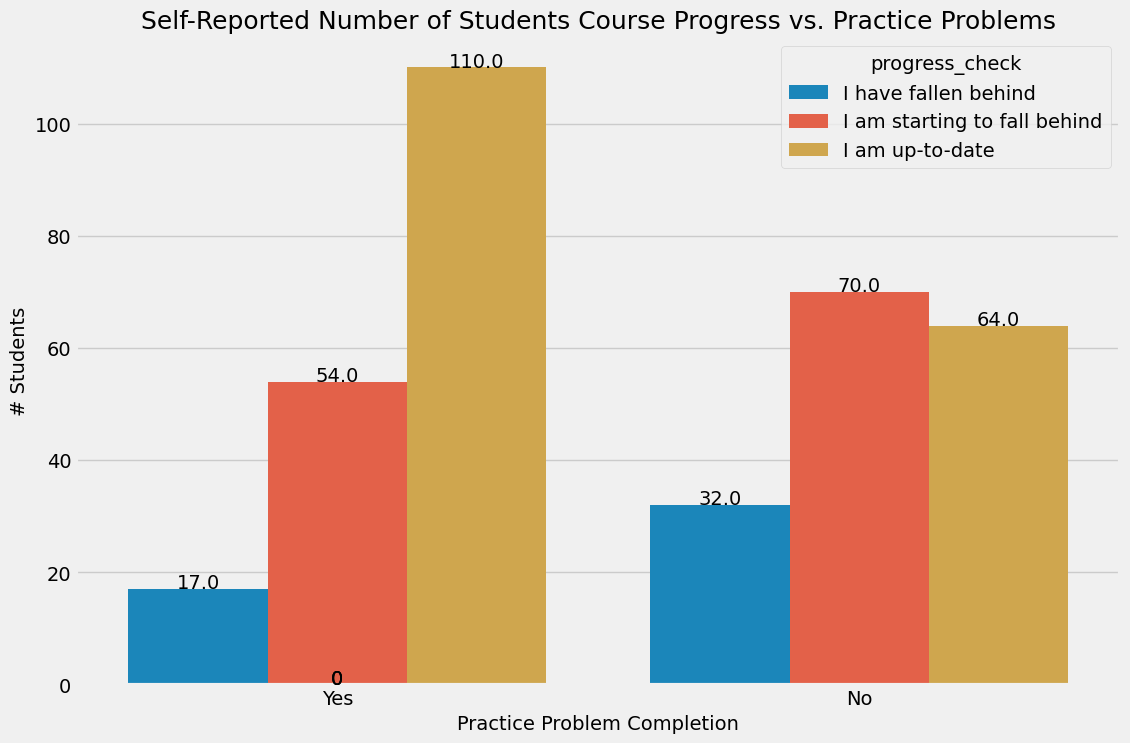

In [61]:
# how many students are not attending their assigned lecture section?
plt.figure(figsize=(12,8)) 

progress_numeric = {
    'I have fallen behind': 0,
    'I am starting to fall behind': 1,
    'I am up-to-date': 2
}

combined_df['progress_numeric'] = combined_df['progress_check'].map(progress_numeric)

combined_df = combined_df.sort_values(by=['progress_numeric'])

plt.title('Self-Reported Number of Students Course Progress vs. Practice Problems', fontsize = 18)

ax = sns.countplot(x="practice_problems", hue="progress_check", data=combined_df) 

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, height ,ha="center")

ax.set_xlabel('Practice Problem Completion', fontsize=14)
ax.set_ylabel('# Students', fontsize=14)

plt.show()

# Word Cloud: Single Word for How Students are Feeling

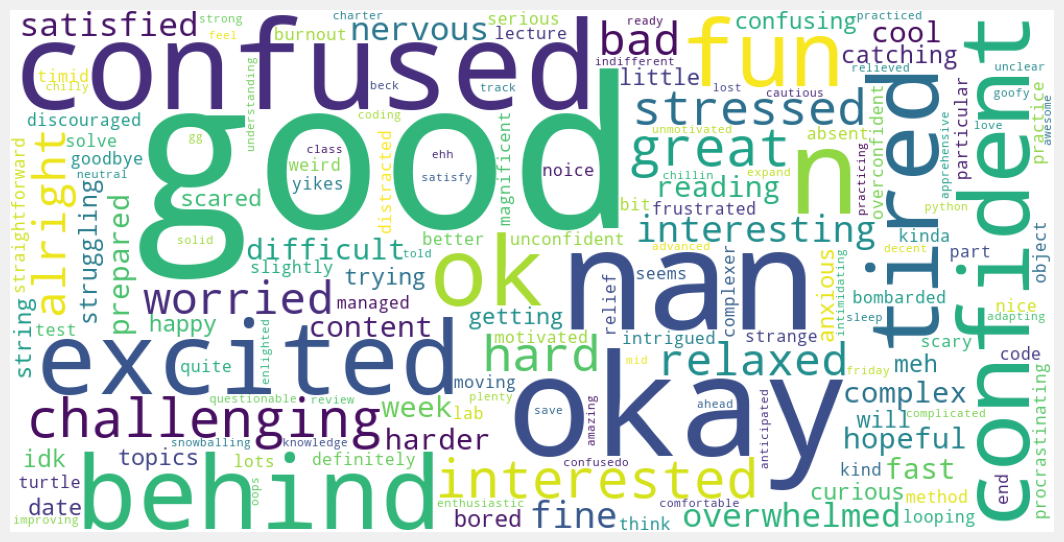

In [62]:
#a word cloud is generated to show the most frequently appearing words
word_text = str((combined_df['comment_one_word'].values))
word_text = word_text.lower()

#remove extra characters
extra_chars = ["xa0","\n","'"]

for char in extra_chars:
    word_text = word_text.replace(char,"")

# define word cloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False, width=1000, height=500).generate(word_text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

# List of Topics Students are Confused With

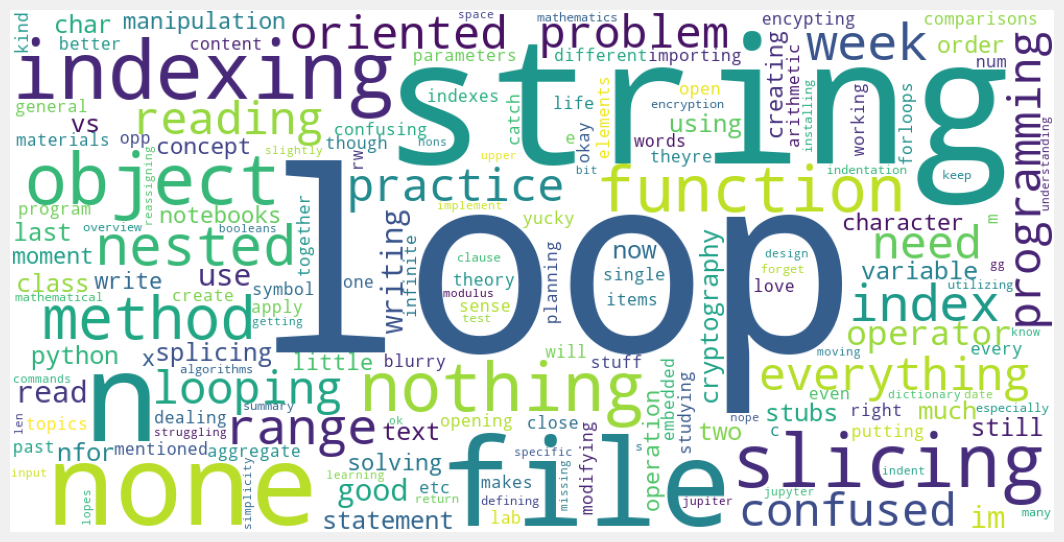

In [63]:
#a word cloud is generated to show the most frequently appearing words
word_text = str((combined_df['confused_topics'].values))
word_text = word_text.lower()

#remove extra characters
extra_chars = ["xa0","\n","'","nan",]

for char in extra_chars:
    word_text = word_text.replace(char,"")

# define word cloud
stopwords = set(STOPWORDS)
confused_topics_words = WordCloud(stopwords=stopwords, background_color="white", collocations=False, width=1000, height=500).generate(word_text)
plt.figure(figsize=(12,8))
plt.imshow(confused_topics_words)
plt.axis("off")

plt.show()

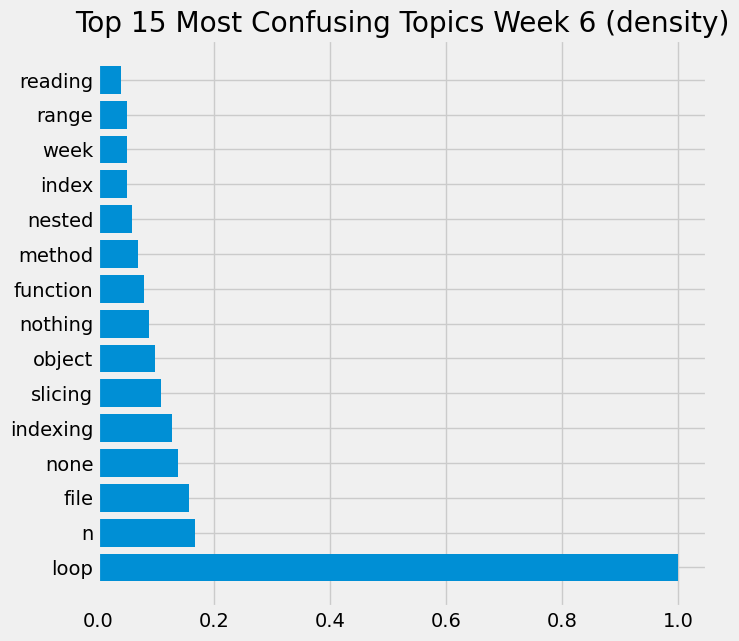

In [64]:
# how many students attended more than one instructor session last week (i.e. both Kinsella and Rosu lectures)
plt.figure(figsize=(7,7)) 
plt.title("Top 15 Most Confusing Topics Week {} (density)".format(week))

name = list(dict(confused_topics_words.words_).keys())[0:1] + list(dict(confused_topics_words.words_).keys())[2:16]
values = list(dict(confused_topics_words.words_).values())[0:1] + list(dict(confused_topics_words.words_).values())[2:16]

plt.barh(name, values)
plt.show()

# Sentiment Analysis: Look at "One Comment" Responses from Students

In [65]:
# describe the observed polarity
combined_df[['polarity']].describe()

polarity
count  352.000000
mean     0.538352
std      1.293367
min     -2.500000
25%      0.000000
50%      0.000000
75%      1.900000
max      5.300000

In [66]:
print("Most positive feedback, Week {}:".format(week))
for text in combined_df.sort_values('polarity').tail(7)['comment_one_word']:
    print('\n  ', text)

Most positive feedback, Week 6:

   great

   Great

   great

   Great

   love you beck!

   Excited (I was told in class on Friday that we would be getting to more challenging topics and I am excited to further expand my Python knowledge by practicing these challenging topics)

   .


In [67]:
print("Most negative feedback, Week {}:".format(week))
for text in combined_df.sort_values('polarity').head(6)['comment_one_word']:
    print('\n  ', text)

Most negative feedback, Week 6:

   not-bad

   Bad

   Not too bad.

   Bad

   frustrated

   scary


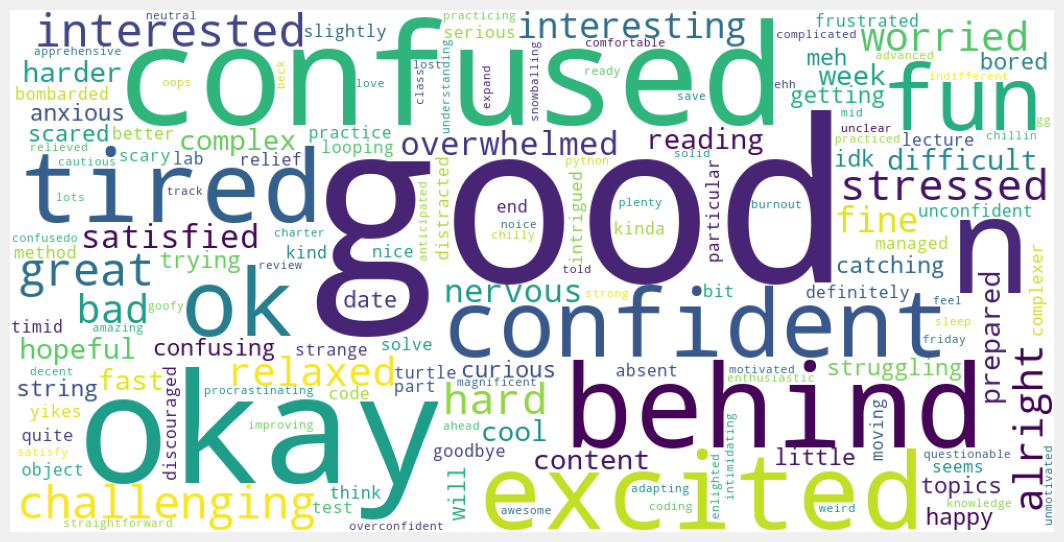

In [68]:
#a word cloud is generated to show the most frequently appearing words
word_text = str((combined_df['comment_one_word'].values))
word_text = word_text.lower()

#remove extra characters
extra_chars = ["xa0","\n","'","nan"]

for char in extra_chars:
    word_text = word_text.replace(char,"")

# define word cloud
stopwords = set(STOPWORDS)
long_answer_words = WordCloud(stopwords=stopwords, background_color="white", collocations=False, width=1000, height=500).generate(word_text)
plt.figure(figsize=(12,8))
plt.imshow(long_answer_words)
plt.axis("off")

plt.show()

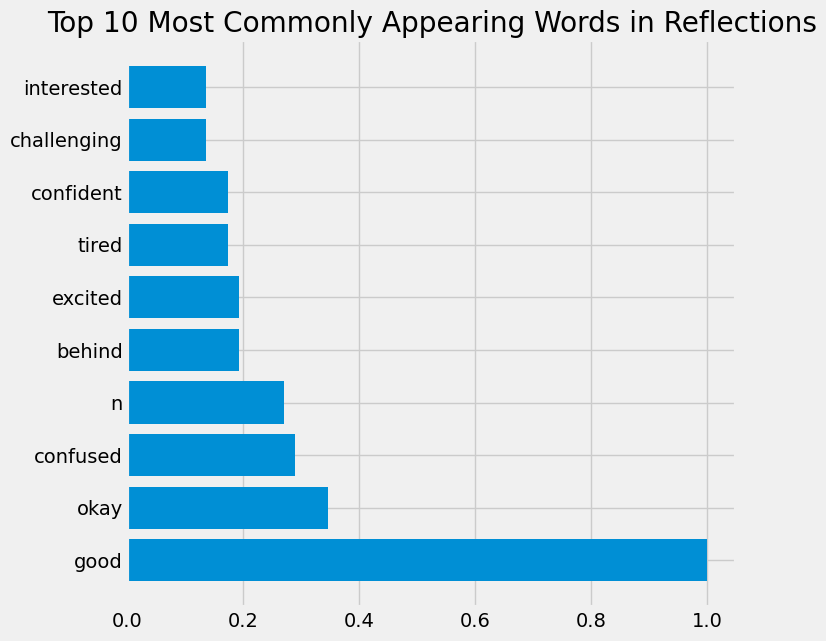

In [69]:
# how many students attended more than one instructor session last week (i.e. both Kinsella and Rosu lectures)
plt.figure(figsize=(7,7)) 
plt.title("Top 10 Most Commonly Appearing Words in Reflections")

name = list(dict(long_answer_words.words_).keys())[0:8] + list(dict(long_answer_words.words_).keys())[10:12]
values = list(dict(long_answer_words.words_).values())[0:8] + list(dict(long_answer_words.words_).values())[10:12]

plt.barh(name, values)
plt.show()

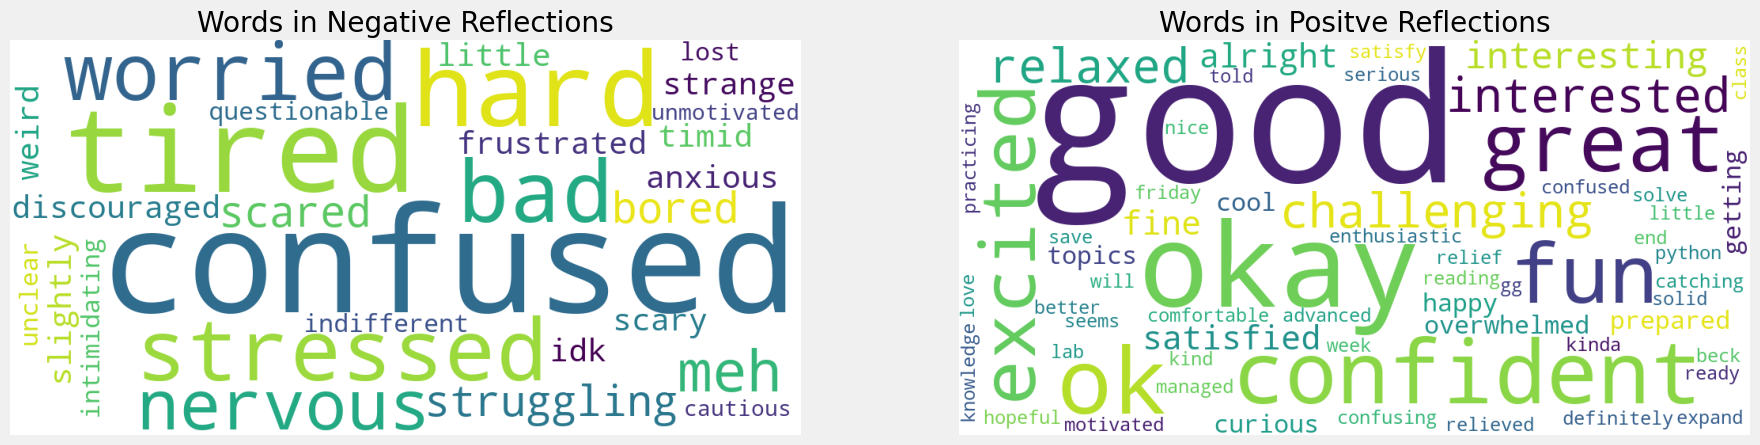

In [70]:
# most commonly appearing words in different polarity reflections
filt = [combined_df[combined_df['polarity']<0], combined_df[combined_df['polarity']>0]]
title = ["Words in Negative Reflections", "Words in Positve Reflections"]

fig, ax = plt.subplots(1,2, figsize=(20, 20))

for index, df in enumerate(filt): 

    word_text = str((df['comment_one_word'].values))
    word_text = word_text.lower()

    #remove extra characters
    extra_chars = ["xa0","\n","'","nan"]

    for char in extra_chars:
        word_text = word_text.replace(char,"")

    # define word cloud
    stopwords = set(STOPWORDS)
    words = WordCloud(stopwords=stopwords, background_color="white", collocations=False, width=1000, height=500).generate(word_text)
    ax[index].imshow(words)
    ax[index].set_title("{}".format(title[index]))
    ax[index].axis("off")

plt.show()
